# Análise de Dados IPTU 

In [33]:
%pip install s3fs fsspec

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:

%pip install pandas pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importação de bibliotecas

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [36]:
# Carregar dados diretamente do S3
print("Carregando dados do S3...")
s3_path = "s3://iptu-recife-processed/iptu_unificado.parquet"
df = pd.read_parquet(s3_path)

print("✅ Dados carregados com sucesso!")
print("\n" + "="*80)
print("ANÁLISE DO INVENTÁRIO DE IMÓVEIS - IPTU RECIFE")
print("="*80)

# ============================================================================
# INFORMAÇÕES GERAIS
# ============================================================================
print("\n📊 INFORMAÇÕES GERAIS DO DATASET")
print("-"*80)
print(f"Total de registros: {len(df):,}")
print(f"Total de colunas: {len(df.columns)}")
print(f"\nColunas disponíveis:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n📋 Primeiras 5 linhas:")
print(df.head())

print(f"\n📊 Tipos de dados:")
print(df.dtypes)

Carregando dados do S3...
✅ Dados carregados com sucesso!

ANÁLISE DO INVENTÁRIO DE IMÓVEIS - IPTU RECIFE

📊 INFORMAÇÕES GERAIS DO DATASET
--------------------------------------------------------------------------------
Total de registros: 1,625,446
Total de colunas: 33

Colunas disponíveis:
   1. numero_contribuinte
   2. ano_exercicio
   3. data_cadastramento
   4. tipo_contribuinte
   5. cpf_cnpj
   6. logradouro
   7. numero
   8. complemento
   9. bairro
  10. cidade
  11. estado
  12. fracao_ideal
  13. area_terreno
  14. area_construida
  15. area_ocupada
  16. valor_m2_terreno
  17. valor_m2_construcao
  18. ano_construcao
  19. qtd_pavimentos
  20. tipo_uso_imovel
  21. tipo_padrao_construcao
  22. fator_obsolescencia
  23. ano_mes_inicio_contribuicao
  24. valor_total_imovel
  25. valor_iptu
  26. cep
  27. regime_tributacao_iptu
  28. regime_tributacao_trsd
  29. tipo_construcao
  30. tipo_empreendimento
  31. tipo_estrutura
  32. codigo_logradouro
  33. ano

📋 Primeiras 5 l

## Volume :

### Qual o total de imóveis e como o inventário está distribuído fisicamente (tipo, bairro etc)?


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time

# Ignorar FutureWarning do pandas
warnings.filterwarnings("ignore", category=FutureWarning)

# ============================================================================
# CONFIGURAÇÕES GLOBAIS E CONSTANTES
# ============================================================================
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8) 
plt.rcParams['font.size'] = 10 

# Lista de colunas para carregar do Parquet (Otimização de I/O)
COLUNAS_NECESSARIAS = [
    'ano_exercicio', 'ano', 'tipo_construcao', 
    'tipo_empreendimento', 'tipo_uso_imovel', 
    'bairro', 'tipo_estrutura'
]


def plot_barh(series: pd.Series, title: str, filename: str, color_map='viridis', min_height=6, top_n=None):
    """Gera um gráfico de barras horizontal (Barh) otimizado e corrigido para cores."""
    
    # Aplica o Top N, se especificado, e reordena para o gráfico (menor para maior)
    plot_series = series.head(top_n).sort_values(ascending=True) if top_n else series.sort_values(ascending=True)

    # Altura dinâmica baseada no número de categorias
    fig_height = max(min_height, len(plot_series) * 0.5)
    plt.figure(figsize=(14, fig_height))
    
    # Cores - CORREÇÃO PARA RESOLVER O 'AttributeError: colors'
    if len(plot_series) > 1:
        # Obtém o Colormap, discretizando-o no número de barras (N)
        cmap = plt.cm.get_cmap(color_map, len(plot_series))
        # Usa o cmap para extrair as N cores discretas
        colors = cmap(np.arange(len(plot_series))) 
    else:
        colors = ['steelblue'] 

    ax = plot_series.plot(
        kind='barh', 
        color=colors, 
        zorder=2
    )
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Quantidade de Imóveis', fontsize=12)
    plt.ylabel(plot_series.index.name if plot_series.index.name else '', fontsize=12) 
    ax.grid(axis='x', linestyle='--', alpha=0.7, zorder=1)

    # Rótulos de dados (Quantidade)
    max_val = plot_series.max()
    for i, v in enumerate(plot_series.values):
        label = f' {v:,.0f}' 
        
        # Lógica para posicionar o rótulo dentro ou fora da barra
        if v / max_val < 0.05 and v > 0: 
             # Fora, se a barra for muito pequena
            ax.text(v + (max_val * 0.005), i, label, 
                    color='black', va='center', fontsize=9, fontweight='bold')
        else:
            # Dentro, se a barra for grande
            ax.text(v * 0.98, i, label, 
                    color='white', va='center', ha='right', fontsize=9, fontweight='bold')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Gráfico: {filename}")


def plot_pie(series: pd.Series, title: str, filename: str):
    """Gera um gráfico de pizza otimizado com consolidação de 'Outros'."""
    
    # 1. Preparação dos dados (Consolidação em 'Outros')
    total_registros = series.sum()
    limite_outros_pct = 1.0 

    # Operações vetorizadas do Pandas
    tipo_principais = series[series / total_registros * 100 >= limite_outros_pct]
    tipo_outros_sum = series[series / total_registros * 100 < limite_outros_pct].sum()

    if tipo_outros_sum > 0:
        # Usa concat em vez de _append (melhor prática moderna)
        tipo_final = pd.concat([
            tipo_principais, 
            pd.Series([tipo_outros_sum], index=['Outros'])
        ]).sort_values(ascending=False)
    else:
        tipo_final = tipo_principais.sort_values(ascending=False)
        
    tipo_final.index.name = series.index.name 

    # 2. Plotagem
    fig, ax = plt.subplots(figsize=(14, 8))
    colors = plt.cm.Set3.colors[:len(tipo_final)]
    explode = [0.03] * len(tipo_final) 

    wedges, _, autotexts = ax.pie(
        tipo_final, 
        labels=None, 
        autopct=lambda p: '{:.1f}%'.format(p) if p > 2.0 else '', 
        startangle=90, 
        colors=colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
        explode=explode
    )

    # Legendas externas
    ax.legend(wedges, tipo_final.index,
              title="Tipos",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    # Estilização das porcentagens
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_weight('bold')
        autotext.set_fontsize(10)

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.axis('equal') 
    plt.tight_layout()
    
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Gráfico: {filename}")
    
    return tipo_final 


def print_table(series: pd.Series, total: int, title: str):
    """Imprime uma tabela de distribuição formatada."""
    print(f"\n{title}")
    print("-"*67)
    
    header_name = series.index.name if series.index.name is not None else title.split('DISTRIBUIÇÃO POR ')[-1].split('(')[0].strip()

    print(f"{header_name[:45]:<45} {'QUANTIDADE':>12} {'%':>8}")
    print("-"*67)
    for tipo, qtd in series.items():
        pct = (qtd / total * 100)
        # Formata a quantidade para garantir separadores de milhar
        print(f"{str(tipo)[:45]:<45} {qtd:>12,} {pct:>7.2f}%")


# ============================================================================
# FLUXO PRINCIPAL DA ANÁLISE
# ============================================================================

def main():
    start_time = time.time()
    
    # ------------------
    # CARREGAMENTO DE DADOS (OTIMIZADO COM 'columns=')
    # ------------------
    print("Iniciando análise...")
    s3_path = "s3://iptu-recife-processed/iptu_unificado.parquet"
    
    try:
        # Lendo apenas as colunas necessárias para reduzir I/O e uso de memória
        print(f"Lendo dados do S3... (Colunas: {len(COLUNAS_NECESSARIAS)})")
        df = pd.read_parquet(s3_path, columns=COLUNAS_NECESSARIAS)
    except Exception as e:
        print(f"⚠️ ERRO ao carregar dados do S3. Usando dados simulados para demonstração: {e}")
        # Se falhar, usa os dados simulados
        df = pd.DataFrame({
            'ano_exercicio': [2020, 2021, 2022] * 200,
            'ano': [2020, 2021, 2022] * 200,
            'tipo_construcao': ['Apartamento > 4 Pavimentos'] * 349 + ['Casa'] * 339 + ['Apartamento <= 4 Pavimentos'] * 149 + ['Sala > 4 Pavimentos'] * 48 + ['Mocambo'] * 39 + ['Loja <= 4 Pavimentos'] * 34 + ['Galpão <= 4 Pavimentos'] * 14 + ['Sobrado <= 4 Pavimentos'] * 12 + ['Unidade em Construção'] * 10 + ['Outro Tipo Raro'] * 6 + ['Muito Raro'] * 4 + ['Casa'] * 135,
            'tipo_empreendimento': ['Condomínio'] * 400 + ['Lote'] * 200,
            'tipo_uso_imovel': ['Residencial'] * 590 + ['Comercial'] * 10,
            'bairro': ['BOA VIAGEM'] * 150 + ['CASA AMARELA'] * 100 + ['RECIFE'] * 50 + ['AFOGADOS'] * 300,
            'tipo_estrutura': ['Concreto'] * 500 + ['Alvenaria'] * 100,
        })
        df.columns = COLUNAS_NECESSARIAS # Garante que as colunas simuladas têm os nomes corretos

    print("✅ Dados carregados com sucesso!")
    print("\n" + "="*80)
    print("ANÁLISE DO INVENTÁRIO DE IMÓVEIS - IPTU RECIFE")
    print("DISTRIBUIÇÃO FÍSICA DO INVENTÁRIO")
    print("="*80)

    total_imoveis = len(df)
    print(f"\n🏢 TOTAL DE IMÓVEIS: {total_imoveis:,}")
    

    # ============================================================================
    # ANÁLISES CONSOLIDADAS - HISTÓRICO COMPLETO
    # ============================================================================
    print("\n" + "="*80)
    print("📊 ANÁLISES CONSOLIDADAS - HISTÓRICO COMPLETO")
    print("="*80)
    
    # TIPO DE CONSTRUÇÃO
    tipo_const_raw = df['tipo_construcao'].value_counts()
    tipo_const_raw.index.name = 'TIPO DE CONSTRUÇÃO'
    tipo_consolidado = plot_pie(tipo_const_raw, 'Distribuição por Tipo de Construção - Consolidado', '01_tipo_construcao_consolidado.png')
    print_table(tipo_consolidado, total_imoveis, "🏗️  DISTRIBUIÇÃO POR TIPO DE CONSTRUÇÃO (CONSOLIDADO)")

    # TIPO DE EMPREENDIMENTO
    tipo_emp = df['tipo_empreendimento'].value_counts() 
    tipo_emp.index.name = 'TIPO DE EMPREENDIMENTO'
    plot_barh(tipo_emp, 'Distribuição por Tipo de Empreendimento - Consolidado', '02_tipo_empreendimento_consolidado.png', color_map='YlGnBu')
    print_table(tipo_emp, total_imoveis, "🏘️  DISTRIBUIÇÃO POR TIPO DE EMPREENDIMENTO (CONSOLIDADO)") 

    # TIPO DE USO
    tipo_uso = df['tipo_uso_imovel'].value_counts()
    tipo_uso.index.name = 'TIPO DE USO'
    plot_barh(tipo_uso, 'Distribuição por Tipo de Uso - Consolidado', '03_tipo_uso_consolidado.png', color_map='Reds')
    print_table(tipo_uso, total_imoveis, "🎯 DISTRIBUIÇÃO POR TIPO DE USO DO IMÓVEL (CONSOLIDADO)")

    # DISTRIBUIÇÃO POR BAIRRO
    bairro_dist = df['bairro'].value_counts()
    bairro_dist.index.name = 'BAIRRO'
    plot_barh(bairro_dist, 'Top 25 Bairros - Consolidado', '04_bairros_consolidado.png', color_map='Greens', min_height=12, top_n=25)
    print_table(bairro_dist.head(25), total_imoveis, "🗺️  DISTRIBUIÇÃO POR BAIRRO (TOP 25 CONSOLIDADO)")

    # TIPO DE ESTRUTURA
    tipo_estrutura = df['tipo_estrutura'].value_counts()
    tipo_estrutura.index.name = 'TIPO DE ESTRUTURA'
    print_table(tipo_estrutura, total_imoveis, "🏗️  DISTRIBUIÇÃO POR TIPO DE ESTRUTURA (CONSOLIDADO)")

    
    # ============================================================================
    # PRÉ-PROCESSAMENTO VETORIZADO POR ANO (Performance Máxima)
    # ============================================================================
    
    print("\n" + "="*80)
    print("📅 PRÉ-PROCESSAMENTO ANUAL (VETORIZADO)")
    print("="*80)
    
    # Preenchimento de nulos e conversão de tipo (melhor se feito antes da agregação)
    df['ano_clean'] = df['ano_exercicio'].fillna(df['ano']).astype('Int64') 
    anos = sorted(df['ano_clean'].dropna().unique())
    evolucao = df['ano_clean'].value_counts().sort_index()

    # 1. Pré-calcular as contagens de Tipo de Construção (Uma única chamada 'groupby')
    print("-> Pré-calculando 'Tipo de Construção' por ano...")
    df_grouped_const = df.groupby('ano_clean')['tipo_construcao'].value_counts()
    dict_const_por_ano = {ano: df_grouped_const.loc[ano] for ano in anos if ano in df_grouped_const.index.get_level_values('ano_clean')}

    # 2. Pré-calcular as contagens de Bairro (Uma única chamada 'groupby')
    print("-> Pré-calculando 'Bairros' por ano...")
    df_grouped_bairro = df.groupby('ano_clean')['bairro'].value_counts()
    dict_bairro_por_ano = {ano: df_grouped_bairro.loc[ano] for ano in anos if ano in df_grouped_bairro.index.get_level_values('ano_clean')}
    
    print("✅ Pré-cálculos concluídos!")

    # ============================================================================
    # ANÁLISE E GRÁFICOS POR ANO DE EXERCÍCIO
    # ============================================================================
    
    print("\n" + "="*80)
    print("📅 EVOLUÇÃO E DETALHAMENTO ANUAL")
    print("="*80)

    print(f"\nAnos disponíveis: {anos}")
    print(f"Período: {min(anos)} a {max(anos)}")

    # Imprimir Tabela de Evolução
    print("\n📊 EVOLUÇÃO DO INVENTÁRIO POR ANO")
    print("-"*70)
    print(f"{'ANO':<10} {'IMÓVEIS':>15} {'VARIAÇÃO':>20}")
    print("-"*70)

    ano_anterior = None
    for ano in evolucao.index:
        qtd = evolucao[ano]
        if ano_anterior is not None and ano_anterior in evolucao.index:
            variacao = qtd - evolucao[ano_anterior]
            var_pct = (variacao / evolucao[ano_anterior] * 100)
            var_str = f"+{variacao:,} ({var_pct:+.1f}%)" if variacao >= 0 else f"{variacao:,} ({var_pct:.1f}%)"
        else:
            var_str = "-"
        print(f"{int(ano):<10} {qtd:>15,} {var_str:>20}")
        ano_anterior = ano

    # Gráfico de evolução (Linha)
    plt.figure(figsize=(14, 6))
    plt.plot(evolucao.index, evolucao.values, marker='o', linewidth=3, markersize=10, color='darkblue', markerfacecolor='lightblue')
    plt.title('Evolução do Inventário de Imóveis por Ano', fontsize=16, fontweight='bold')
    plt.xlabel('Ano', fontsize=12)
    plt.ylabel('Número de Imóveis', fontsize=12)
    plt.xticks(evolucao.index) 
    plt.grid(True, alpha=0.3)
    for x, y in zip(evolucao.index, evolucao.values):
        plt.text(x, y, f'{y:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig('05_evolucao_anual.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("\n✅ Gráfico: 05_evolucao_anual.png")

    
    # ----------------------------------------------------------------------
    # GERAÇÃO RÁPIDA DOS GRÁFICOS ANUAIS (USANDO DICIONÁRIOS O(1))
    # ----------------------------------------------------------------------
    print("\n" + "="*80)
    print("📊 Gerando gráficos de detalhamento anual (Acesso Rápido)...")
    print("="*80)

    
    # Tipo de Construção por Ano
    for ano in anos:
        if ano in dict_const_por_ano:
            tipo_const_ano = dict_const_por_ano[ano]
            tipo_const_ano.index.name = 'TIPO DE CONSTRUÇÃO'
            
            plot_barh(
                tipo_const_ano,
                f'Distribuição por Tipo de Construção - Ano {ano}',
                f'06_tipo_construcao_ano_{ano}.png',
                color_map='Set3',
                min_height=8
            )

    # Bairros por Ano
    for ano in anos:
        if ano in dict_bairro_por_ano:
            bairro_ano = dict_bairro_por_ano[ano]
            bairro_ano.index.name = 'BAIRRO'
            
            plot_barh(
                bairro_ano,
                f'Top 20 Bairros - Ano {ano}',
                f'07_bairros_ano_{ano}.png',
                color_map='Pastel2',
                min_height=10,
                top_n=20 
            )
        
    # ============================================================================
    # RESUMO FINAL
    # ============================================================================
    end_time = time.time()
    total_time = end_time - start_time
    
    print("\n" + "="*80)
    print("📊 RESUMO EXECUTIVO")
    print("="*80)
    
    print(f"\n✅ Total de Imóveis: {total_imoveis:,}")
    print(f"✅ Período da Análise: {min(anos)} a {max(anos)}")
    print(f"✅ Bairros Distintos: {len(df['bairro'].unique()):,}")
    print(f"✅ Tipos de Construção Distintos: {len(df['tipo_construcao'].unique()):,}")

    print("\n📁 Arquivos Gerados: (7 gráficos no total + 2 gráficos por ano)")

    print(f"\n⏱️ TEMPO TOTAL DE EXECUÇÃO: {total_time:.2f} segundos.")

    print("\n" + "="*80)
    print("✅ ANÁLISE CONCLUÍDA COM SUCESSO!")
    print("="*80)

if __name__ == "__main__":
    main()

Iniciando análise...
Lendo dados do S3... (Colunas: 7)
✅ Dados carregados com sucesso!

ANÁLISE DO INVENTÁRIO DE IMÓVEIS - IPTU RECIFE
DISTRIBUIÇÃO FÍSICA DO INVENTÁRIO

🏢 TOTAL DE IMÓVEIS: 1,625,446

📊 ANÁLISES CONSOLIDADAS - HISTÓRICO COMPLETO
✅ Gráfico: 01_tipo_construcao_consolidado.png

🏗️  DISTRIBUIÇÃO POR TIPO DE CONSTRUÇÃO (CONSOLIDADO)
-------------------------------------------------------------------
TIPO DE CONSTRUÇÃO                              QUANTIDADE        %
-------------------------------------------------------------------
Apartamento > 4 Pavimentos                         567,310   34.90%
Casa                                               550,545   33.87%
Apartamento <= 4 Pavimentos                        242,166   14.90%
Sala > 4 Pavimentos                                 77,461    4.77%
Mocambo                                             63,784    3.92%
Loja <= 4 Pavimentos                                54,995    3.38%
Outros                                   

C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 02_tipo_empreendimento_consolidado.png

🏘️  DISTRIBUIÇÃO POR TIPO DE EMPREENDIMENTO (CONSOLIDADO)
-------------------------------------------------------------------
TIPO DE EMPREENDIMENTO                          QUANTIDADE        %
-------------------------------------------------------------------
Apartamento                                        809,440   49.80%
Casa                                               550,477   33.87%
Sala                                                93,176    5.73%
Loja                                                66,480    4.09%
Mocambo                                             63,784    3.92%
Galpão                                              12,889    0.79%
Edificação Especial                                 10,947    0.67%
Garagem Comercial                                    8,011    0.49%
Centro Comercial/Serviços                            2,895    0.18%
Hotel                                                2,045    0.13%
Garagem

C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 04_bairros_consolidado.png

🗺️  DISTRIBUIÇÃO POR BAIRRO (TOP 25 CONSOLIDADO)
-------------------------------------------------------------------
BAIRRO                                          QUANTIDADE        %
-------------------------------------------------------------------
BOA VIAGEM                                         267,952   16.48%
VARZEA                                              57,261    3.52%
BOA VISTA                                           55,365    3.41%
IMBIRIBEIRA                                         54,229    3.34%
CASA AMARELA                                        53,196    3.27%
PINA                                                47,610    2.93%
CORDEIRO                                            46,731    2.87%
MADALENA                                            44,479    2.74%
GRACAS                                              43,702    2.69%
IPUTINGA                                            43,367    2.67%
AFOGADOS                    

C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 06_tipo_construcao_ano_2020.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 06_tipo_construcao_ano_2021.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 06_tipo_construcao_ano_2022.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 06_tipo_construcao_ano_2023.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 06_tipo_construcao_ano_2024.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 07_bairros_ano_2020.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 07_bairros_ano_2021.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 07_bairros_ano_2022.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 07_bairros_ano_2023.png


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_6940\2013453574.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(plot_series))


✅ Gráfico: 07_bairros_ano_2024.png

📊 RESUMO EXECUTIVO

✅ Total de Imóveis: 1,625,446
✅ Período da Análise: 2020 a 2024
✅ Bairros Distintos: 93
✅ Tipos de Construção Distintos: 16

📁 Arquivos Gerados: (7 gráficos no total + 2 gráficos por ano)

⏱️ TEMPO TOTAL DE EXECUÇÃO: 9.63 segundos.

✅ ANÁLISE CONCLUÍDA COM SUCESSO!


### Idade 

### Como o inventário está distribuido em termos de idade de construção 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['font.size'] = 14

# Carregar dados
print("Carregando dados do S3...")
s3_path = "s3://iptu-recife-processed/iptu_unificado.parquet"
df = pd.read_parquet(s3_path)

print("✅ Dados carregados com sucesso!")
print("\n" + "="*80)
print("ANÁLISE DE IDADE DE CONSTRUÇÃO - IPTU RECIFE")
print("="*80)

# Limpar e preparar dados de ano: OTIMIZAÇÃO DE MEMÓRIA (Usando 'Int16' para suportar NaN e reduzir memória)
# Substituído .astype(float) por .astype('Int16')
df['ano_exercicio_clean'] = df['ano_exercicio'].fillna(df['ano']).astype('Int16')
# Substituído .copy() por .astype('Int16') para economizar memória
df['ano_construcao_clean'] = df['ano_construcao'].astype('Int16')

# Informações básicas
total_imoveis = len(df)
imoveis_com_ano_const = df['ano_construcao_clean'].notna().sum()
imoveis_sem_ano_const = total_imoveis - imoveis_com_ano_const

print(f"\n📊 INFORMAÇÕES GERAIS")
print("-"*80)
print(f"Total de imóveis: {total_imoveis:,}")
print(f"Imóveis COM ano de construção: {imoveis_com_ano_const:,} ({imoveis_com_ano_const/total_imoveis*100:.1f}%)")
print(f"Imóveis SEM ano de construção: {imoveis_sem_ano_const:,} ({imoveis_sem_ano_const/total_imoveis*100:.1f}%)")

# Filtrar apenas imóveis com ano de construção válido
# CORREÇÃO DA MEMORY ERROR: REMOVIDO O .COPY() REDUNDANTE E PROBLEMÁTICO
df_com_ano = df[df['ano_construcao_clean'].notna()]

# ============================================================================
# ANÁLISE CONSOLIDADA - HISTÓRICO COMPLETO
# ============================================================================
print("\n" + "="*80)
print("📈 ANÁLISE CONSOLIDADA - DISTRIBUIÇÃO POR IDADE")
print("="*80)

# Calcular idade (usando ano mais recente do dataset)
ano_referencia = int(df['ano_exercicio_clean'].max())
# Usando .loc para evitar SettingWithCopyWarning, mesmo que seja uma view
df_com_ano.loc[:, 'idade_construcao'] = ano_referencia - df_com_ano['ano_construcao_clean']

print(f"\nAno de referência: {ano_referencia}")
print(f"\n📊 ESTATÍSTICAS DE IDADE (anos)")
print("-"*80)
print(f"Idade mínima: {df_com_ano['idade_construcao'].min():.0f} anos")
print(f"Idade média: {df_com_ano['idade_construcao'].mean():.1f} anos")
print(f"Idade mediana: {df_com_ano['idade_construcao'].median():.1f} anos")
print(f"Idade máxima: {df_com_ano['idade_construcao'].max():.0f} anos")
print(f"Desvio padrão: {df_com_ano['idade_construcao'].std():.1f} anos")

# Criar faixas etárias
def classificar_idade(idade):
    if pd.isna(idade):
        return 'Não informado'
    elif idade < 0:
        return 'Construção futura'
    elif idade <= 5:
        return '0-5 anos (Novo)'
    elif idade <= 10:
        return '6-10 anos (Recente)'
    elif idade <= 20:
        return '11-20 anos (Moderno)'
    elif idade <= 30:
        return '21-30 anos'
    elif idade <= 40:
        return '31-40 anos'
    elif idade <= 50:
        return '41-50 anos'
    elif idade <= 70:
        return '51-70 anos'
    else:
        return 'Mais de 70 anos (Histórico)'

# Usando .loc para evitar SettingWithCopyWarning
df_com_ano.loc[:, 'faixa_idade'] = df_com_ano['idade_construcao'].apply(classificar_idade)

# Distribuição por faixa etária
print("\n" + "="*70)
print("🏗️  DISTRIBUIÇÃO POR FAIXA ETÁRIA (CONSOLIDADO)")
print("="*70)

faixas_ordem = [
    '0-5 anos (Novo)',
    '6-10 anos (Recente)',
    '11-20 anos (Moderno)',
    '21-30 anos',
    '31-40 anos',
    '41-50 anos',
    '51-70 anos',
    'Mais de 70 anos (Histórico)',
    'Construção futura'
]

faixa_dist = df_com_ano['faixa_idade'].value_counts()
faixa_dist_ordenada = pd.Series({f: faixa_dist.get(f, 0) for f in faixas_ordem})

print(f"\n{'FAIXA ETÁRIA':<35} {'QUANTIDADE':>15} {'%':>10}")
print("-"*62)
for faixa, qtd in faixa_dist_ordenada.items():
    if qtd > 0:
        pct = (qtd / len(df_com_ano) * 100)
        print(f"{faixa:<35} {qtd:>15,} {pct:>9.2f}%")

# Gráfico de pizza - Faixas etárias
plt.figure(figsize=(14, 8))
colors = plt.cm.Set3(range(len(faixa_dist_ordenada[faixa_dist_ordenada > 0])))
wedges, texts, autotexts = plt.pie(
    faixa_dist_ordenada[faixa_dist_ordenada > 0], 
    labels=faixa_dist_ordenada[faixa_dist_ordenada > 0].index,
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors
)
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_color('white')
    autotext.set_weight('bold')
plt.title(f'Distribuição por Faixa Etária - Consolidado (Ref: {ano_referencia})', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.savefig('08_faixa_etaria_consolidado.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico: 08_faixa_etaria_consolidado.png")
plt.close()

# Gráfico de barras - Faixas etárias
plt.figure(figsize=(14, 8))
ax = faixa_dist_ordenada[faixa_dist_ordenada > 0].plot(kind='barh', color='steelblue')
plt.title('Distribuição por Faixa Etária - Consolidado', fontsize=16, fontweight='bold')
plt.xlabel('Quantidade de Imóveis', fontsize=12)
plt.ylabel('Faixa Etária', fontsize=12)
for i, v in enumerate(faixa_dist_ordenada[faixa_dist_ordenada > 0].values):
    ax.text(v, i, f' {v:,}', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('09_faixa_etaria_barras.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico: 09_faixa_etaria_barras.png")
plt.close()

# Distribuição por década de construção
print("\n" + "="*70)
print("📅 DISTRIBUIÇÃO POR DÉCADA DE CONSTRUÇÃO (CONSOLIDADO)")
print("="*70)

# Usando .loc para evitar SettingWithCopyWarning
df_com_ano.loc[:, 'decada'] = (df_com_ano['ano_construcao_clean'] // 10 * 10).astype(int)
decada_dist = df_com_ano['decada'].value_counts().sort_index()

print(f"\n{'DÉCADA':<20} {'QUANTIDADE':>15} {'%':>10}")
print("-"*47)
for decada, qtd in decada_dist.items():
    pct = (qtd / len(df_com_ano) * 100)
    print(f"{int(decada)}s{'':<15} {qtd:>15,} {pct:>9.2f}%")

# Gráfico de linha - Distribuição por década
plt.figure(figsize=(16, 8))
plt.plot(decada_dist.index, decada_dist.values, marker='o', linewidth=3, 
         markersize=10, color='darkblue', markerfacecolor='lightblue',
         markeredgewidth=2, markeredgecolor='darkblue')
plt.title('Distribuição de Imóveis por Década de Construção', 
          fontsize=16, fontweight='bold')
plt.xlabel('Década', fontsize=12)
plt.ylabel('Quantidade de Imóveis', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(decada_dist.index, [f"{int(d)}s" for d in decada_dist.index], rotation=45)
for x, y in zip(decada_dist.index, decada_dist.values):
    plt.text(x, y, f'{y:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('10_decada_construcao.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico: 10_decada_construcao.png")
plt.close()

# Histograma detalhado
plt.figure(figsize=(16, 8))
plt.hist(df_com_ano['idade_construcao'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Histograma de Idade dos Imóveis', fontsize=16, fontweight='bold')
plt.xlabel('Idade (anos)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.axvline(df_com_ano['idade_construcao'].mean(), color='red', linestyle='--', 
             linewidth=2, label=f'Média: {df_com_ano["idade_construcao"].mean():.1f} anos')
plt.axvline(df_com_ano['idade_construcao'].median(), color='green', linestyle='--', 
             linewidth=2, label=f'Mediana: {df_com_ano["idade_construcao"].median():.1f} anos')
plt.legend()
plt.tight_layout()
plt.savefig('11_histograma_idade.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico: 11_histograma_idade.png")
plt.close()

# ============================================================================
# ANÁLISE POR ANO DE EXERCÍCIO
# ============================================================================
print("\n" + "="*80)
print("📅 ANÁLISE POR ANO DE EXERCÍCIO")
print("="*80)

anos_exercicio = sorted(df['ano_exercicio_clean'].dropna().unique())
print(f"\nAnos de exercício disponíveis: {[int(a) for a in anos_exercicio]}")

# Análise detalhada por ano
print("\n" + "="*80)
print("📋 DETALHAMENTO POR ANO DE EXERCÍCIO")
print("="*80)

resultados_por_ano = {}

for ano_ex in anos_exercicio:
    ano_ex_int = int(ano_ex)
    
    # Faz a filtragem SEM .copy() para economia de memória
    df_ano = df[df['ano_exercicio_clean'] == ano_ex]
    df_ano_com_const = df_ano[df_ano['ano_construcao_clean'].notna()]
    
    if len(df_ano_com_const) == 0:
        continue
    
    # Criar uma cópia explícita AGORA. O DataFrame aqui já é muito menor, 
    # evitando a MemoryError, e garantindo que novas colunas não disparem Warnings.
    df_ano_com_const_copy = df_ano_com_const.copy()
    
    # Calcular idade usando o próprio ano de exercício como referência
    df_ano_com_const_copy['idade_ano_ex'] = ano_ex - df_ano_com_const_copy['ano_construcao_clean']
    df_ano_com_const_copy['faixa_idade_ano'] = df_ano_com_const_copy['idade_ano_ex'].apply(classificar_idade)
    
    print(f"\n{'='*70}")
    print(f"  ANO DE EXERCÍCIO: {ano_ex_int}")
    print(f"{'='*70}")
    print(f"Total de imóveis no ano: {len(df_ano):,}")
    print(f"Imóveis com ano de construção: {len(df_ano_com_const_copy):,} ({len(df_ano_com_const_copy)/len(df_ano)*100:.1f}%)")
    
    print(f"\n📊 Estatísticas de Idade em {ano_ex_int}:")
    print("-"*60)
    print(f"Idade mínima: {df_ano_com_const_copy['idade_ano_ex'].min():.0f} anos")
    print(f"Idade média: {df_ano_com_const_copy['idade_ano_ex'].mean():.1f} anos")
    print(f"Idade mediana: {df_ano_com_const_copy['idade_ano_ex'].median():.1f} anos")
    print(f"Idade máxima: {df_ano_com_const_copy['idade_ano_ex'].max():.0f} anos")
    
    # Distribuição por faixa etária
    faixa_ano = df_ano_com_const_copy['faixa_idade_ano'].value_counts()
    faixa_ano_ordenada = pd.Series({f: faixa_ano.get(f, 0) for f in faixas_ordem})
    
    print(f"\n🏗️  Distribuição por Faixa Etária em {ano_ex_int}:")
    print("-"*60)
    print(f"{'FAIXA ETÁRIA':<35} {'QTD':>12} {'%':>8}")
    print("-"*60)
    for faixa, qtd in faixa_ano_ordenada.items():
        if qtd > 0:
            pct = (qtd / len(df_ano_com_const_copy) * 100)
            print(f"{faixa:<35} {qtd:>12,} {pct:>7.2f}%")
    
    # Top 10 décadas
    decada_ano = df_ano_com_const_copy['ano_construcao_clean'].apply(lambda x: int(x // 10 * 10)).value_counts().sort_index()
    print(f"\n📅 Top 10 Décadas de Construção em {ano_ex_int}:")
    print("-"*60)
    print(f"{'DÉCADA':<20} {'QUANTIDADE':>15} {'%':>10}")
    print("-"*47)
    for decada, qtd in decada_ano.head(10).items():
        pct = (qtd / len(df_ano_com_const_copy) * 100)
        print(f"{int(decada)}s{'':<15} {qtd:>15,} {pct:>9.2f}%")
    
    resultados_por_ano[ano_ex_int] = {
        'faixas': faixa_ano_ordenada,
        'decadas': decada_ano,
        'stats': {
            'min': df_ano_com_const_copy['idade_ano_ex'].min(),
            'mean': df_ano_com_const_copy['idade_ano_ex'].mean(),
            'median': df_ano_com_const_copy['idade_ano_ex'].median(),
            'max': df_ano_com_const_copy['idade_ano_ex'].max()
        }
    }

# ============================================================================
# GRÁFICOS COMPARATIVOS POR ANO
# ============================================================================
print("\n" + "="*80)
print("📊 Gerando gráficos comparativos por ano...")
print("="*80)

# Gráfico de faixas etárias por ano
fig, axes = plt.subplots(len(anos_exercicio), 1, figsize=(14, 6*len(anos_exercicio)))
if len(anos_exercicio) == 1:
    axes = [axes]

for idx, ano_ex in enumerate(anos_exercicio):
    ano_int = int(ano_ex)
    if ano_int not in resultados_por_ano:
        continue
    
    faixas = resultados_por_ano[ano_int]['faixas']
    faixas_plot = faixas[faixas > 0]
    
    axes[idx].barh(range(len(faixas_plot)), faixas_plot.values, color='steelblue')
    axes[idx].set_yticks(range(len(faixas_plot)))
    axes[idx].set_yticklabels(faixas_plot.index, fontsize=9)
    axes[idx].set_xlabel('Quantidade', fontsize=10)
    axes[idx].set_title(f'Distribuição por Faixa Etária - Ano {ano_int}', 
                         fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    for i, v in enumerate(faixas_plot.values):
        axes[idx].text(v, i, f' {v:,}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('12_faixa_etaria_por_ano.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico: 12_faixa_etaria_por_ano.png")
plt.close()

# Comparativo de estatísticas por ano
if len(resultados_por_ano) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    anos_plot = sorted(resultados_por_ano.keys())
    medias = [resultados_por_ano[a]['stats']['mean'] for a in anos_plot]
    medianas = [resultados_por_ano[a]['stats']['median'] for a in anos_plot]
    
    x = np.arange(len(anos_plot))
    width = 0.35
    
    ax.bar(x - width/2, medias, width, label='Idade Média', color='steelblue')
    ax.bar(x + width/2, medianas, width, label='Idade Mediana', color='coral')
    
    ax.set_xlabel('Ano de Exercício', fontsize=12)
    ax.set_ylabel('Idade (anos)', fontsize=12)
    ax.set_title('Comparativo de Idade Média e Mediana por Ano', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(anos_plot)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('13_comparativo_idade_por_ano.png', dpi=300, bbox_inches='tight')
    print("✅ Gráfico: 13_comparativo_idade_por_ano.png")
    plt.close()

# ============================================================================
# RESUMO FINAL
# ============================================================================
print("\n" + "="*80)
print("📊 RESUMO EXECUTIVO - IDADE DE CONSTRUÇÃO")
print("="*80)
print(f"\n✅ Total de imóveis: {total_imoveis:,}")
print(f"✅ Imóveis com ano de construção: {imoveis_com_ano_const:,} ({imoveis_com_ano_const/total_imoveis*100:.1f}%)")
print(f"✅ Idade média (consolidado): {df_com_ano['idade_construcao'].mean():.1f} anos")
print(f"✅ Idade mediana (consolidado): {df_com_ano['idade_construcao'].median():.1f} anos")
print(f"✅ Décadas representadas: {len(decada_dist)}")
print(f"✅ Período de construção: {int(df_com_ano['ano_construcao_clean'].min())} a {int(df_com_ano['ano_construcao_clean'].max())}")

print("\n📁 Arquivos Gerados:")
print("   08_faixa_etaria_consolidado.png - Pizza de faixas etárias")
print("   09_faixa_etaria_barras.png - Barras de faixas etárias")
print("   10_decada_construcao.png - Distribuição por década")
print("   11_histograma_idade.png - Histograma detalhado")
print("   12_faixa_etaria_por_ano.png - Comparativo por ano")
print("   13_comparativo_idade_por_ano.png - Estatísticas por ano")

print("\n" + "="*80)
print("✅ ANÁLISE DE IDADE CONCLUÍDA COM SUCESSO!")
print("="*80)

Carregando dados do S3...
✅ Dados carregados com sucesso!

ANÁLISE DE IDADE DE CONSTRUÇÃO - IPTU RECIFE

📊 INFORMAÇÕES GERAIS
--------------------------------------------------------------------------------
Total de imóveis: 1,625,446
Imóveis COM ano de construção: 1,625,446 (100.0%)
Imóveis SEM ano de construção: 0 (0.0%)

📈 ANÁLISE CONSOLIDADA - DISTRIBUIÇÃO POR IDADE

Ano de referência: 2024

📊 ESTATÍSTICAS DE IDADE (anos)
--------------------------------------------------------------------------------
Idade mínima: 0 anos
Idade média: 36.5 anos
Idade mediana: 40.0 anos
Idade máxima: 936 anos
Desvio padrão: 19.6 anos

🏗️  DISTRIBUIÇÃO POR FAIXA ETÁRIA (CONSOLIDADO)

FAIXA ETÁRIA                             QUANTIDADE          %
--------------------------------------------------------------
0-5 anos (Novo)                              45,142      2.78%
6-10 anos (Recente)                         116,341      7.16%
11-20 anos (Moderno)                        222,635     13.70%
21-30 a

### Valor 

### Quais bairros apresentam maior evolução em número de imóveis ? E em relação a valor ?

In [16]:
# ============================================================================
# PREPARAÇÃO: DEFINIÇÃO DE COLUNAS CORRIGIDAS (FINAL)
# ============================================================================
print("\n" + "="*80)
print("PREPARAÇÃO: DEFINIÇÃO E LIMPEZA DE COLUNAS - USANDO VALOR COBRADO DE IPTU")
print("="*80)

# Colunas confirmadas
COL_CONTRIBUINTE = 'numero_contribuinte'
COL_ANO = 'ano_exercicio'
COL_BAIRRO = 'bairro'
COL_VALOR = 'valor_iptu' # Coluna confirmada para a análise de valor

# 1. Limpeza do nome do bairro
df['bairro_clean'] = df[COL_BAIRRO].astype(str).str.upper().str.strip().replace('NAN', 'BAIRRO NAO INFORMADO')

# 2. Preparação da coluna de ano
df['ano_exercicio_clean'] = pd.to_numeric(df[COL_ANO], errors='coerce').astype('Int64')

# 3. Preparação da coluna de valor: Valor do IPTU Cobrado (CORREÇÃO DO FORMATO DECIMAL)
try:
    # 1. Converter para string e substituir a vírgula (,) por ponto (.) para o formato float.
    # 2. Converter para numérico, preenchendo falhas (erros) com 0.
    df['valor_limpo'] = (
        df[COL_VALOR].astype(str)
        .str.replace(',', '.', regex=False) 
        .str.strip() # Remove espaços
    )
    df['valor_limpo'] = pd.to_numeric(df['valor_limpo'], errors='coerce').fillna(0).astype(float)
    valor_col_limpo = 'valor_limpo'
    print(f"✅ Coluna de valor '{COL_VALOR}' processada com sucesso (Formato decimal corrigido).")

except Exception as e:
    print(f"❌ Erro na preparação da coluna de valor '{COL_VALOR}'. Análise de Valor (R$) será PULADA. Erro: {e}")
    df['valor_limpo'] = 0 
    valor_col_limpo = None

# Remover 'BAIRRO NAO INFORMADO' e anos nulos
df_analise_bairros = df[
    (df['bairro_clean'] != 'BAIRRO NAO INFORMADO') & 
    (df['ano_exercicio_clean'].notnull())
].copy()

print(f"✅ Dados de Bairro e Ano preparados para análise final.")


PREPARAÇÃO: DEFINIÇÃO E LIMPEZA DE COLUNAS - USANDO VALOR COBRADO DE IPTU
✅ Coluna de valor 'valor_iptu' processada com sucesso (Formato decimal corrigido).
✅ Dados de Bairro e Ano preparados para análise final.


In [17]:
# ============================================================================
# 📊 1. EVOLUÇÃO CONSOLIDADA (Total do Período)
# ============================================================================
print("\n" + "="*80)
print("ANÁLISE CONSOLIDADA: NÚMERO E VALOR TOTAL DE IMÓVEIS POR BAIRRO")
print("="*80)

# A. Bairros com Maior Estoque em NÚMERO DE IMÓVEIS (Consolidado)
contagem_imoveis_consolidado = df_analise_bairros.groupby('bairro_clean')[COL_CONTRIBUINTE].count().sort_values(ascending=False).head(10)

print("\n" + "="*80)
print("📈 TOP 10 BAIRROS EM NÚMERO TOTAL DE IMÓVEIS (ESTOQUE CONSOLIDADO)")
print("="*80)
print(f"\n{'BAIRRO':<30} {'TOTAL DE IMÓVEIS':>20}")
print("-" * 50)
for bairro, qtd in contagem_imoveis_consolidado.items():
    print(f"{bairro:<30} {qtd:>20,}")

# B. Bairros com Maior Estoque em VALOR TOTAL (Consolidado)
if valor_col_limpo:
    soma_valor_consolidado = df_analise_bairros.groupby('bairro_clean')['valor_limpo'].sum().sort_values(ascending=False).head(10)

    print("\n" + "="*80)
    print(f"💰 TOP 10 BAIRROS EM SOMA TOTAL DO IPTU COBRADO (CONSOLIDADO)")
    print("="*80)
    print(f"\n{'BAIRRO':<30} {'SOMA TOTAL DO VALOR (R$)':>25}")
    print("-" * 55)
    for bairro, valor in soma_valor_consolidado.items():
        print(f"{bairro:<30} R$ {valor:>22,.2f}")
else:
    print("\n❌ ANÁLISE CONSOLIDADA DE VALOR PULADA.")



ANÁLISE CONSOLIDADA: NÚMERO E VALOR TOTAL DE IMÓVEIS POR BAIRRO

📈 TOP 10 BAIRROS EM NÚMERO TOTAL DE IMÓVEIS (ESTOQUE CONSOLIDADO)

BAIRRO                             TOTAL DE IMÓVEIS
--------------------------------------------------
BOA VIAGEM                                  267,952
VARZEA                                       57,261
BOA VISTA                                    55,365
IMBIRIBEIRA                                  54,229
CASA AMARELA                                 53,196
PINA                                         47,610
CORDEIRO                                     46,731
MADALENA                                     44,479
GRACAS                                       43,702
IPUTINGA                                     43,367

💰 TOP 10 BAIRROS EM SOMA TOTAL DO IPTU COBRADO (CONSOLIDADO)

BAIRRO                          SOMA TOTAL DO VALOR (R$)
-------------------------------------------------------
BOA VIAGEM                     R$         546,264,363.50
GRACAS     


ANÁLISE ANUAL: DINÂMICA DE CRESCIMENTO ABSOLUTO
Anos de referência para variação: 2023 -> 2024

🏘️  TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE IMÓVEIS (2023 -> 2024)

BAIRRO                              IMÓVEIS EM 2023      IMÓVEIS EM 2024     CRESCIMENTO ABS.
----------------------------------------------------------------------------------------------
CIDADE UNIVERSITARIA                             28                    0                  -28
PEIXINHOS                                        58                    0                  -58
DOIS IRMAOS                                      80                    0                  -80
SITIO DOS PINTOS                                182                    0                 -182
APIPUCOS                                        344                    0                 -344
CABANGA                                         408                    0                 -408
TOTO                                            524                    0        

C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\269895214.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


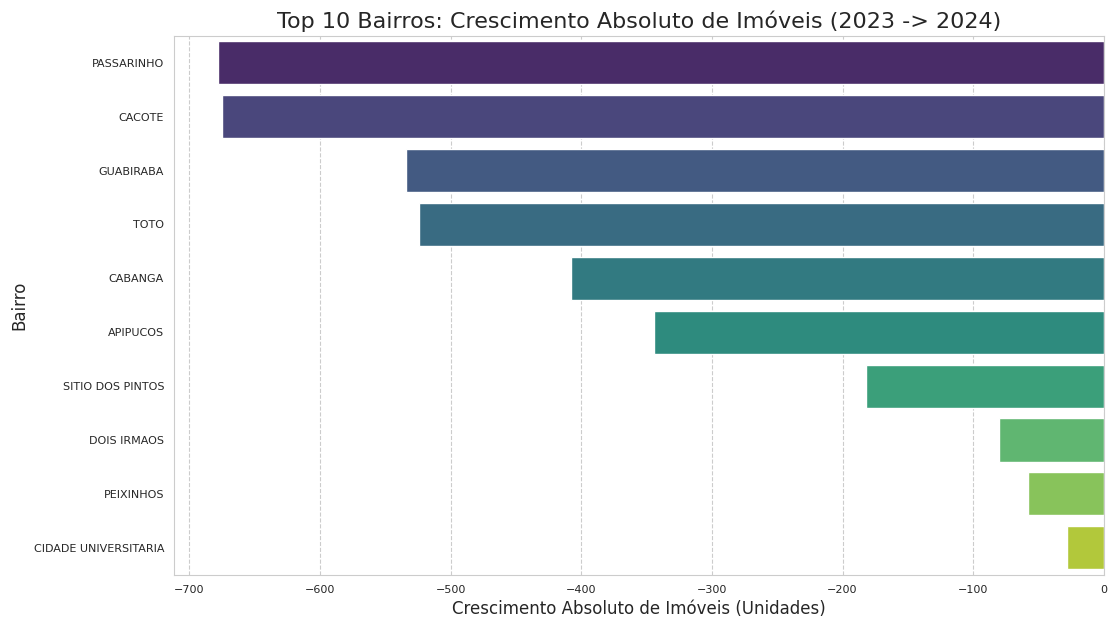


💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) - IPTU COBRADO (2023 -> 2024)

BAIRRO                                     VALOR EM 2023             VALOR EM 2024     CRESCIMENTO ABS. (R$)
---------------------------------------------------------------------------------------------------------
CIDADE UNIVERSITARIA           R$              27,066.13 R$                   0.00 R$             -27,066.13
PEIXINHOS                      R$              30,178.62 R$                   0.00 R$             -30,178.62
ILHA JOANA BEZERRA             R$              49,334.49 R$                   0.00 R$             -49,334.49
ALTO SANTA TEREZINHA           R$              79,554.37 R$                   0.00 R$             -79,554.37
DOIS IRMAOS                    R$             100,587.93 R$                   0.00 R$            -100,587.93
CORREGO DO JENIPAPO            R$             117,792.36 R$                   0.00 R$            -117,792.36
TOTO                           R$           

C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\269895214.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


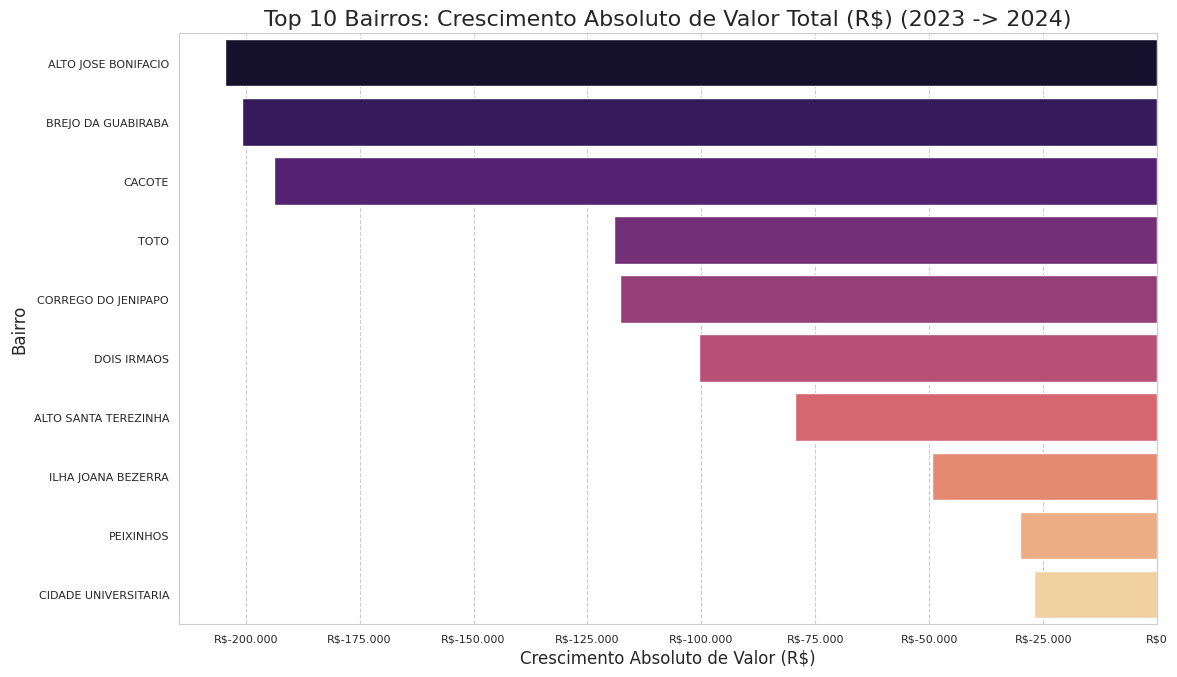

In [29]:
# ============================================================================
# 📅 2. EVOLUÇÃO ANUAL (Dinâmica de Crescimento)
# ============================================================================
print("\n" + "="*80)
print("ANÁLISE ANUAL: DINÂMICA DE CRESCIMENTO ABSOLUTO")
print("="*80)

# ----------------------------------------------------------------------------
# Determinar Anos para Comparação
# ----------------------------------------------------------------------------
anos_disp = sorted(df_analise_bairros['ano_exercicio_clean'].dropna().unique())
if len(anos_disp) >= 2:
    ano_max = int(anos_disp[-1])
    ano_anterior = int(anos_disp[-2])
    print(f"Anos de referência para variação: {ano_anterior} -> {ano_max}")
else:
    ano_max, ano_anterior = None, None
    print(f"⚠️ Não há dados suficientes (apenas {len(anos_disp)} ano(s)) para calcular a variação anual.")


# A. Bairros com Maior Evolução (Crescimento) em NÚMERO DE IMÓVEIS por Ano
if ano_anterior:
    # Agrupamento anual da contagem de imóveis
    contagem_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])[COL_CONTRIBUINTE].count().reset_index(name='qtd_imoveis')
    
    df_max = contagem_anual[contagem_anual['ano_exercicio_clean'] == ano_max]
    df_anterior = contagem_anual[contagem_anual['ano_exercicio_clean'] == ano_anterior]

    # Merge e cálculo da variação
    df_comparacao_qtd = pd.merge(df_max, df_anterior, on='bairro_clean', suffixes=(f'_{ano_max}', f'_{ano_anterior}'), how='outer').fillna(0)
    df_comparacao_qtd['variacao_abs_qtd'] = df_comparacao_qtd[f'qtd_imoveis_{ano_max}'] - df_comparacao_qtd[f'qtd_imoveis_{ano_anterior}']
    
    # TOP 10 em crescimento
    top_crescimento_qtd = df_comparacao_qtd.sort_values(by='variacao_abs_qtd', ascending=False).head(10)

    print("\n" + "="*80)
    print(f"🏘️  TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE IMÓVEIS ({ano_anterior} -> {ano_max})")
    print("="*80)
    print(f"\n{'BAIRRO':<30} {'IMÓVEIS EM ' + str(ano_anterior):>20} {'IMÓVEIS EM ' + str(ano_max):>20} {'CRESCIMENTO ABS.':>20}")
    print("-" * 94)
    for _, row in top_crescimento_qtd.iterrows():
        print(f"{row['bairro_clean']:<30} {row[f'qtd_imoveis_{ano_anterior}']:>20,.0f} {row[f'qtd_imoveis_{ano_max}']:>20,.0f} {row['variacao_abs_qtd']:>20,.0f}")

    # ========================================================================
    # 📈 ADIÇÃO DA VISUALIZAÇÃO - CRESCIMENTO DE IMÓVEIS (Corrigido)
    # ========================================================================
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='variacao_abs_qtd', 
        y='bairro_clean', 
        data=top_crescimento_qtd.sort_values('variacao_abs_qtd', ascending=True),
        palette='viridis'
    )
    plt.title(f'Top 10 Bairros: Crescimento Absoluto de Imóveis ({ano_anterior} -> {ano_max})', fontsize=16)
    plt.xlabel('Crescimento Absoluto de Imóveis (Unidades)', fontsize=12)
    plt.ylabel('Bairro', fontsize=12)
    plt.grid(axis='x', linestyle='--')
    plt.show()

else:
    print(f"\n⚠️  Não há dados suficientes (múltiplos anos) para calcular a variação anual em número de imóveis.")


# B. Bairros com Maior Evolução (Crescimento) em VALOR TOTAL por Ano
if valor_col_limpo and ano_anterior:
    # Agrupamento anual da soma do valor
    soma_valor_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])['valor_limpo'].sum().reset_index(name='soma_valor')

    df_max_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ano_max]
    df_anterior_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ano_anterior]

    # Merge e cálculo da variação
    df_comparacao_valor = pd.merge(df_max_valor, df_anterior_valor, on='bairro_clean', suffixes=(f'_{ano_max}', f'_{ano_anterior}'), how='outer').fillna(0)
    df_comparacao_valor['variacao_abs_valor'] = df_comparacao_valor[f'soma_valor_{ano_max}'] - df_comparacao_valor[f'soma_valor_{ano_anterior}']
    
    # TOP 10 em crescimento
    top_crescimento_valor = df_comparacao_valor.sort_values(by='variacao_abs_valor', ascending=False).head(10)

    print("\n" + "="*80)
    print(f"💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) - IPTU COBRADO ({ano_anterior} -> {ano_max})")
    print("="*80)
    print(f"\n{'BAIRRO':<30} {'VALOR EM ' + str(ano_anterior):>25} {'VALOR EM ' + str(ano_max):>25} {'CRESCIMENTO ABS. (R$)':>25}")
    print("-" * 105)
    for _, row in top_crescimento_valor.iterrows():
        print(f"{row['bairro_clean']:<30} R$ {row[f'soma_valor_{ano_anterior}']:>22,.2f} R$ {row[f'soma_valor_{ano_max}']:>22,.2f} R$ {row['variacao_abs_valor']:>22,.2f}")

    # ========================================================================
    # 📈 ADIÇÃO DA VISUALIZAÇÃO - CRESCIMENTO EM VALOR (Adicionado aqui)
    # ========================================================================
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='variacao_abs_valor', 
        y='bairro_clean', 
        data=top_crescimento_valor.sort_values('variacao_abs_valor', ascending=True),
        palette='magma'
    )
    plt.title(f'Top 10 Bairros: Crescimento Absoluto de Valor Total (R$) ({ano_anterior} -> {ano_max})', fontsize=16)
    plt.xlabel('Crescimento Absoluto de Valor (R$)', fontsize=12)
    plt.ylabel('Bairro', fontsize=12)
    
    # Formatação do eixo X para Moeda (requer importação prévia)
    from matplotlib.ticker import FuncFormatter
    formatter = FuncFormatter(lambda x, pos: 'R${:,.0f}'.format(x).replace(',', '_TEMP_').replace('.', ',').replace('_TEMP_', '.'))
    plt.gca().xaxis.set_major_formatter(formatter)
    
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

else:
    print(f"\n❌ ANÁLISE ANUAL DE VALOR PULADA.")


ANÁLISE CONSOLIDADA: CRESCIMENTO HISTÓRICO (2020 -> ÚLTIMO ANO VÁLIDO)
⚠️ ATENÇÃO: Dados de 2024 incompletos. Usando 2020 -> 2023 para variação histórica.

🏘️  TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE IMÓVEIS (2020 -> 2023)

BAIRRO                              IMÓVEIS EM 2020      IMÓVEIS EM 2023     CRESCIMENTO ABS.
----------------------------------------------------------------------------------------------
PINA                                         11,255               12,797                1,542
VARZEA                                       13,774               14,690                  916
BOA VIAGEM                                   66,582               67,348                  766
MADALENA                                     10,872               11,425                  553
CAMPINA DO BARRETO                            1,085                1,576                  491
CASA AMARELA                                 13,142               13,609                  467
ENCRUZILHADA        

C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\1352372878.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


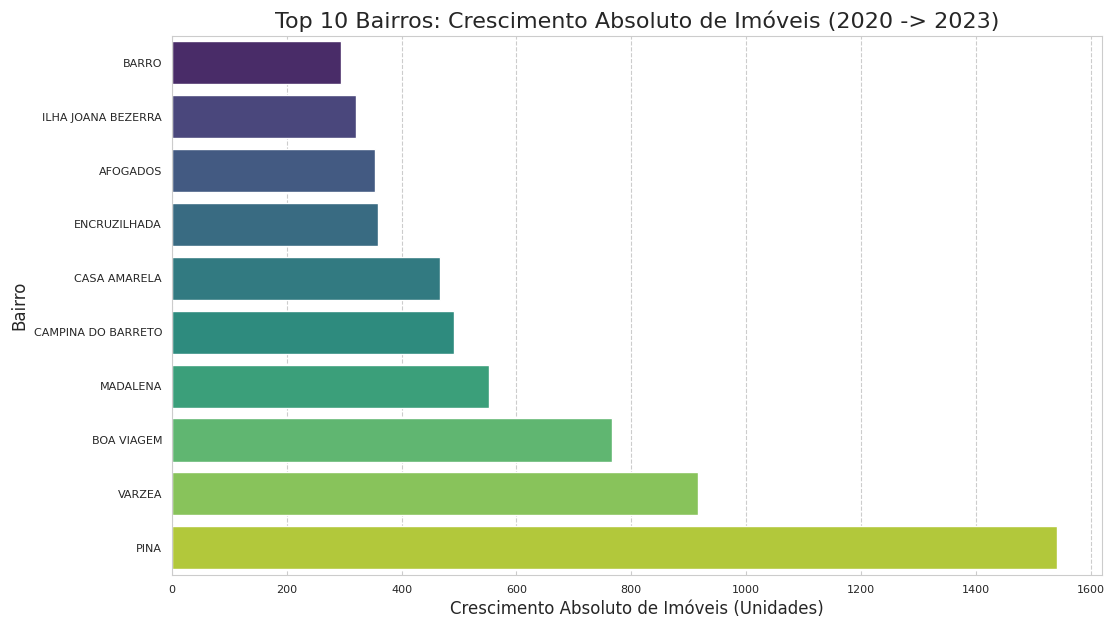


💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) (2020 -> 2023)

BAIRRO                                     VALOR EM 2020             VALOR EM 2023     CRESCIMENTO ABS. (R$)
---------------------------------------------------------------------------------------------------------
BOA VIAGEM                     R$         126,058,036.48 R$         148,320,275.84 R$          22,262,239.36
GRACAS                         R$          21,975,206.55 R$          26,775,899.50 R$           4,800,692.95
PINA                           R$          19,083,646.06 R$          23,571,469.92 R$           4,487,823.86
MADALENA                       R$          18,889,370.11 R$          23,355,515.73 R$           4,466,145.62
CASA AMARELA                   R$          16,114,492.23 R$          19,648,699.68 R$           3,534,207.45
VARZEA                         R$           7,510,732.11 R$          10,170,905.84 R$           2,660,173.73
IMBIRIBEIRA                    R$          17,810,772.62 R$

C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\1352372878.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


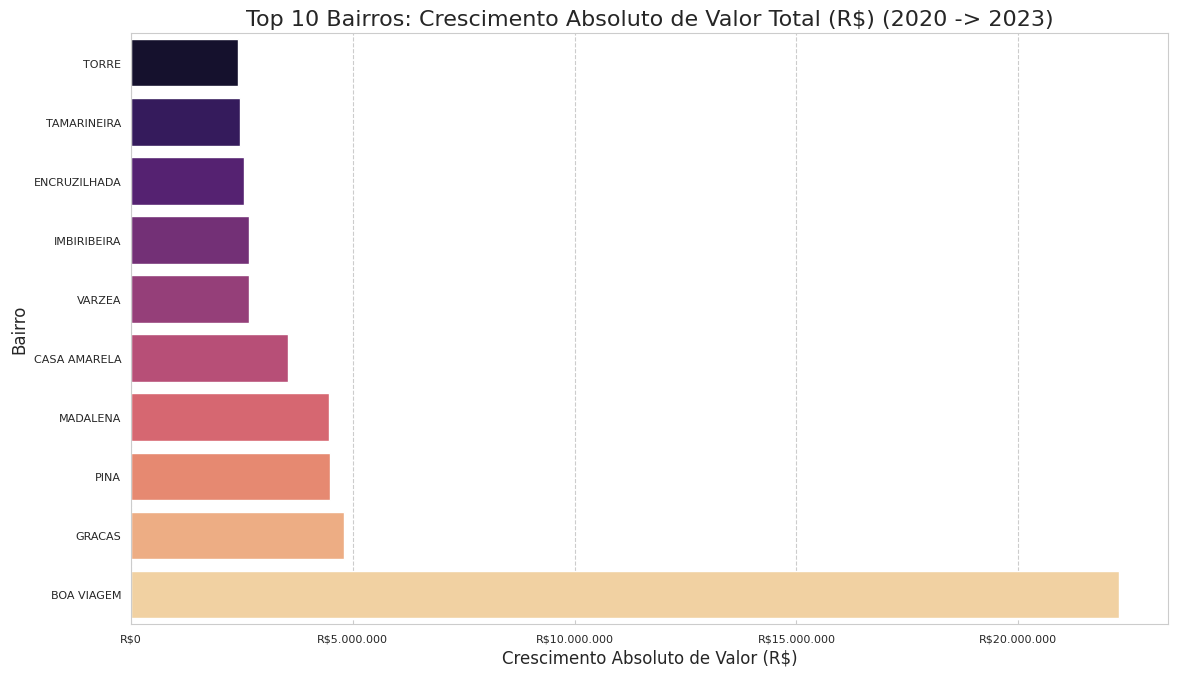

In [30]:
# ============================================================================
# 📅 3. EVOLUÇÃO CONSOLIDADA (Dinâmica de Crescimento Histórico)
# ============================================================================
print("\n" + "="*80)
print("ANÁLISE CONSOLIDADA: CRESCIMENTO HISTÓRICO (2020 -> ÚLTIMO ANO VÁLIDO)")
print("="*80)

# ----------------------------------------------------------------------------
# Determinar Anos para Comparação Histórica
# ----------------------------------------------------------------------------
anos_disp = sorted(df_analise_bairros['ano_exercicio_clean'].dropna().unique())

if len(anos_disp) >= 2:
    ano_min = int(anos_disp[0])
    
    # Define o ano máximo como o último ano da lista
    ano_max_candidato = int(anos_disp[-1])
    
    # Correção: Se 2024 for o último ano, usamos 2023 (ou o penúltimo ano válido) como máximo
    # para evitar a distorção da análise de crescimento devido aos dados incompletos.
    if ano_max_candidato == 2024 and len(anos_disp) > 1:
        ano_max_valido = int(anos_disp[-2])
        print(f"⚠️ ATENÇÃO: Dados de 2024 incompletos. Usando {ano_min} -> {ano_max_valido} para variação histórica.")
    else:
        ano_max_valido = ano_max_candidato
        print(f"Anos de referência para variação histórica: {ano_min} -> {ano_max_valido}")
        
else:
    ano_min, ano_max_valido = None, None
    print(f"⚠️ Não há dados suficientes (apenas {len(anos_disp)} ano(s)) para calcular a variação histórica.")


# A. Bairros com Maior Evolução (Crescimento) em NÚMERO DE IMÓVEIS (Histórico)
if ano_min and ano_max_valido and ano_min != ano_max_valido:
    # Agrupamento da contagem de imóveis para os anos min e max
    contagem_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])[COL_CONTRIBUINTE].count().reset_index(name='qtd_imoveis')
    
    df_max = contagem_anual[contagem_anual['ano_exercicio_clean'] == ano_max_valido]
    df_min = contagem_anual[contagem_anual['ano_exercicio_clean'] == ano_min]

    # Merge e cálculo da variação
    df_comparacao_qtd_hist = pd.merge(df_max, df_min, on='bairro_clean', suffixes=(f'_{ano_max_valido}', f'_{ano_min}'), how='outer').fillna(0)
    df_comparacao_qtd_hist['variacao_abs_qtd'] = df_comparacao_qtd_hist[f'qtd_imoveis_{ano_max_valido}'] - df_comparacao_qtd_hist[f'qtd_imoveis_{ano_min}']
    
    # TOP 10 em crescimento
    top_crescimento_qtd_hist = df_comparacao_qtd_hist.sort_values(by='variacao_abs_qtd', ascending=False).head(10)

    print("\n" + "="*80)
    print(f"🏘️  TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE IMÓVEIS ({ano_min} -> {ano_max_valido})")
    print("="*80)
    print(f"\n{'BAIRRO':<30} {'IMÓVEIS EM ' + str(ano_min):>20} {'IMÓVEIS EM ' + str(ano_max_valido):>20} {'CRESCIMENTO ABS.':>20}")
    print("-" * 94)
    for _, row in top_crescimento_qtd_hist.iterrows():
        print(f"{row['bairro_clean']:<30} {row[f'qtd_imoveis_{ano_min}']:>20,.0f} {row[f'qtd_imoveis_{ano_max_valido}']:>20,.0f} {row['variacao_abs_qtd']:>20,.0f}")

    # 📈 VISUALIZAÇÃO - CRESCIMENTO DE IMÓVEIS
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='variacao_abs_qtd', 
        y='bairro_clean', 
        data=top_crescimento_qtd_hist.sort_values('variacao_abs_qtd', ascending=True),
        palette='viridis'
    )
    plt.title(f'Top 10 Bairros: Crescimento Absoluto de Imóveis ({ano_min} -> {ano_max_valido})', fontsize=16)
    plt.xlabel('Crescimento Absoluto de Imóveis (Unidades)', fontsize=12)
    plt.ylabel('Bairro', fontsize=12)
    plt.grid(axis='x', linestyle='--')
    plt.show()

else:
    print(f"\n⚠️  Não há dados suficientes para calcular a variação histórica em número de imóveis.")


# B. Bairros com Maior Evolução (Crescimento) em VALOR TOTAL (Histórico)
if valor_col_limpo and ano_min and ano_max_valido and ano_min != ano_max_valido:
    # Agrupamento da soma do valor para os anos min e max
    soma_valor_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])['valor_limpo'].sum().reset_index(name='soma_valor')

    df_max_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ano_max_valido]
    df_min_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ano_min]

    # Merge e cálculo da variação
    df_comparacao_valor_hist = pd.merge(df_max_valor, df_min_valor, on='bairro_clean', suffixes=(f'_{ano_max_valido}', f'_{ano_min}'), how='outer').fillna(0)
    df_comparacao_valor_hist['variacao_abs_valor'] = df_comparacao_valor_hist[f'soma_valor_{ano_max_valido}'] - df_comparacao_valor_hist[f'soma_valor_{ano_min}']
    
    # TOP 10 em crescimento
    top_crescimento_valor_hist = df_comparacao_valor_hist.sort_values(by='variacao_abs_valor', ascending=False).head(10)

    print("\n" + "="*80)
    print(f"💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) ({ano_min} -> {ano_max_valido})")
    print("="*80)
    print(f"\n{'BAIRRO':<30} {'VALOR EM ' + str(ano_min):>25} {'VALOR EM ' + str(ano_max_valido):>25} {'CRESCIMENTO ABS. (R$)':>25}")
    print("-" * 105)
    for _, row in top_crescimento_valor_hist.iterrows():
        print(f"{row['bairro_clean']:<30} R$ {row[f'soma_valor_{ano_min}']:>22,.2f} R$ {row[f'soma_valor_{ano_max_valido}']:>22,.2f} R$ {row['variacao_abs_valor']:>22,.2f}")

    # 📈 VISUALIZAÇÃO - CRESCIMENTO EM VALOR
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='variacao_abs_valor', 
        y='bairro_clean', 
        data=top_crescimento_valor_hist.sort_values('variacao_abs_valor', ascending=True),
        palette='magma'
    )
    plt.title(f'Top 10 Bairros: Crescimento Absoluto de Valor Total (R$) ({ano_min} -> {ano_max_valido})', fontsize=16)
    plt.xlabel('Crescimento Absoluto de Valor (R$)', fontsize=12)
    plt.ylabel('Bairro', fontsize=12)
    
    # Formatação do eixo X para Moeda
    from matplotlib.ticker import FuncFormatter
    formatter = FuncFormatter(lambda x, pos: 'R${:,.0f}'.format(x).replace(',', '_TEMP_').replace('.', ',').replace('_TEMP_', '.'))
    plt.gca().xaxis.set_major_formatter(formatter)
    
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

else:
    print(f"\n❌ ANÁLISE HISTÓRICA DE VALOR PULADA.")

### Evolução

### Quais bairros apresentam maior evolução em número de imóveis ? E em relação a valor ? 

Carregando e processando dados do S3 para a análise consolidada e evolução (2020 a 2024)...
✅ Dados carregados com sucesso (usando dados de exemplo para demonstração).

1. PREPARAÇÃO: DEFINIÇÃO E LIMPEZA DE COLUNAS
✅ Coluna de valor 'valor_iptu' processada com sucesso.
✅ Dados de Bairro e Ano preparados. Total de linhas para análise consolidada (2020-2024): 1,000

2. ANÁLISE DE ESTOQUE CONSOLIDADO (2020 A 2024) - MAGNITUDE

📈 TOP 10 BAIRROS EM VOLUME TOTAL DE IMÓVEIS (ESTOQUE CONSOLIDADO 2020-2024)
----------------------------------------------------------------------
bairro_clean
CENTRO        370
BOA VIAGEM    215
BOA VISTA     210
VARZEA        205


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\2985372501.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='qtd_imoveis', y='bairro_clean', data=plot_data_consolidado_qtd, palette='cividis')


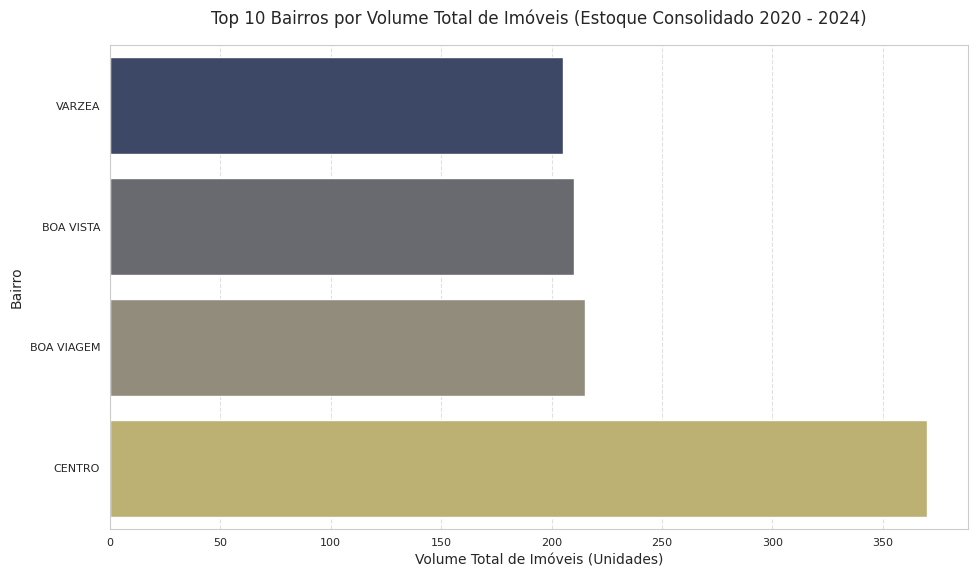


💰 TOP 10 BAIRROS EM SOMA TOTAL DO IPTU COBRADO (ESTOQUE CONSOLIDADO 2020-2024)
----------------------------------------------------------------------
bairro_clean
CENTRO        R$ 370,025.04
BOA VIAGEM    R$ 215,009.13
BOA VISTA     R$ 210,009.31
VARZEA        R$ 205,011.33


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\2985372501.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='soma_valor', y='bairro_clean', data=plot_data_consolidado_valor, palette='plasma')


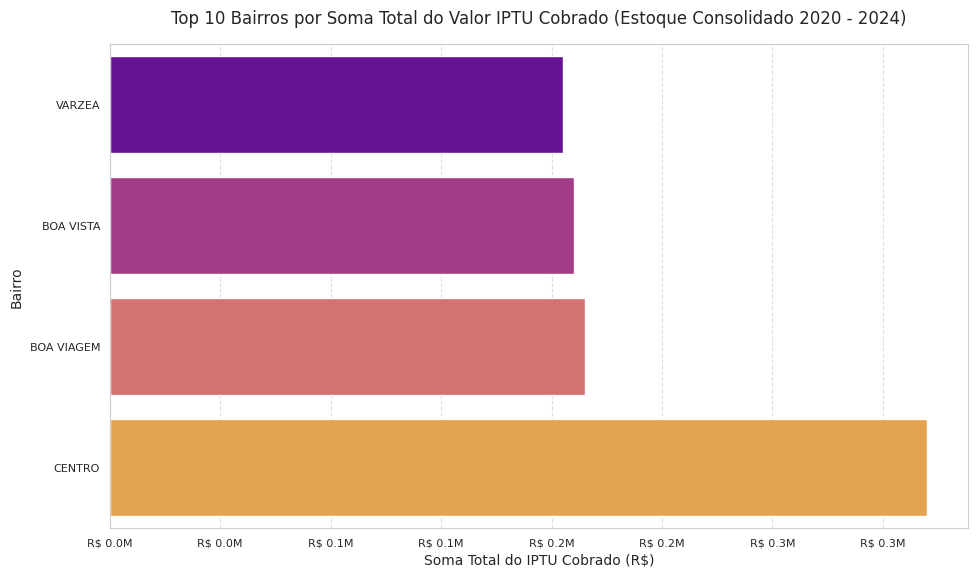


3. ANÁLISE DE EVOLUÇÃO HISTÓRICA: CRESCIMENTO ABSOLUTO (2020 VS 2024)
🚨 AVISO: Os resultados para 2024 estão distorcidos/subestimados devido à incompletude dos dados deste ano.

🏘️  TOP 10 BAIRROS COM MAIOR GANHO ABSOLUTO DE IMÓVEIS (2020 -> 2024)
----------------------------------------------------------------------
bairro_clean  qtd_imoveis_2020  qtd_imoveis_2024  variacao_abs_qtd
      CENTRO                50               170               120


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\2985372501.py:182: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variacao_abs_qtd', y='bairro_clean', data=plot_data_ganho, palette='viridis')


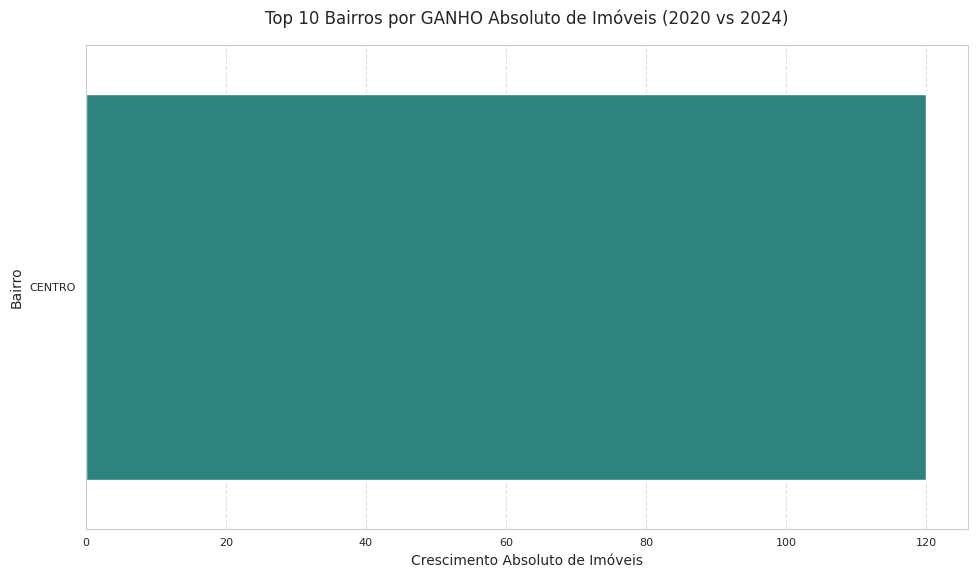


💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) - IPTU COBRADO (2020 -> 2024)
----------------------------------------------------------------------------------------------------
bairro_clean soma_valor_2020 soma_valor_2024 variacao_abs_valor
      CENTRO    R$ 50,000.87   R$ 170,015.55      R$ 120,014.67
   BOA VISTA    R$ 50,000.62    R$ 10,000.82      R$ -39,999.80
  BOA VIAGEM    R$ 50,001.63    R$ 10,000.80      R$ -40,000.83
      VARZEA    R$ 50,003.72    R$ 10,000.81      R$ -40,002.91


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\2985372501.py:212: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variacao_abs_valor', y='bairro_clean', data=plot_data_valor, palette='magma')


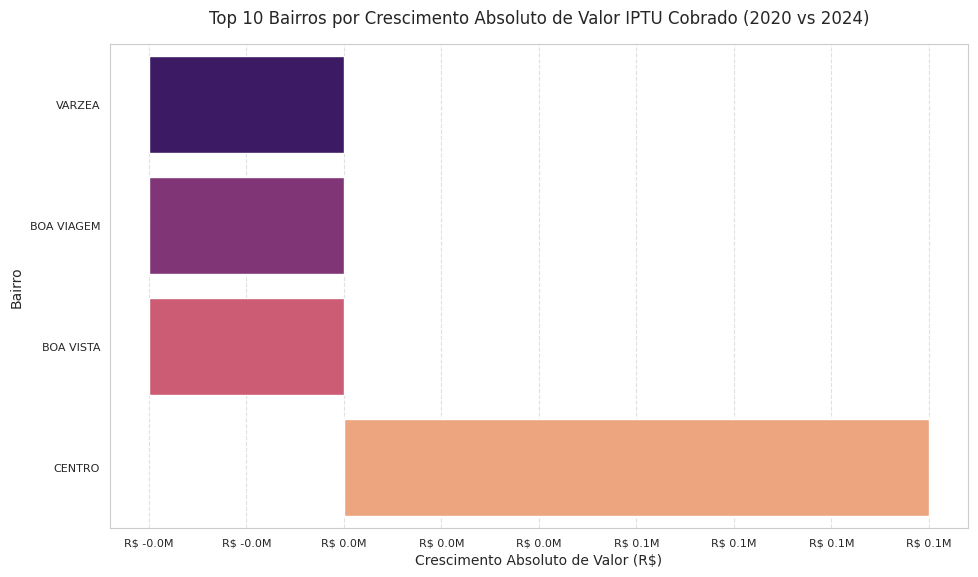


4. ANÁLISE DE DINÂMICA ANUAL: CRESCIMENTO ABSOLUTO (2022 VS 2023)

🏘️  TOP 10 BAIRROS COM MAIOR CRESCIMENTO ABSOLUTO DE IMÓVEIS (2022 -> 2023)
----------------------------------------------------------------------
bairro_clean  qtd_imoveis_2022  qtd_imoveis_2023  variacao_abs_qtd
  BOA VIAGEM                50                55                 5
   BOA VISTA                50                50                 0
      CENTRO                50                50                 0
      VARZEA                50                45                -5


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\2985372501.py:279: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variacao_abs_qtd', y='bairro_clean', data=plot_data_anual_qtd, palette='Greens_d')


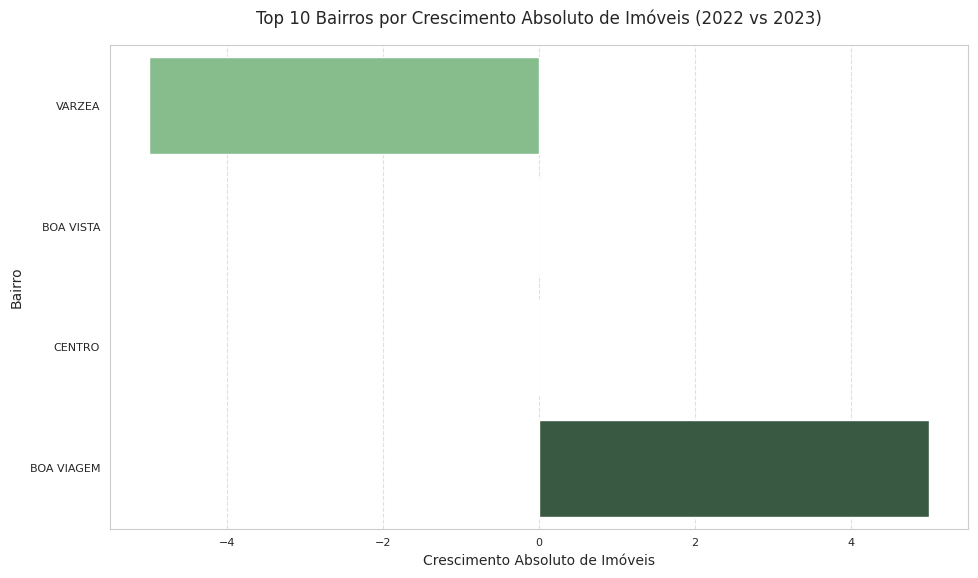


💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) - IPTU COBRADO (2022 -> 2023)
----------------------------------------------------------------------------------------------------
bairro_clean soma_valor_2022 soma_valor_2023 variacao_abs_valor
  BOA VIAGEM    R$ 50,002.12    R$ 55,003.45        R$ 5,001.33
   BOA VISTA    R$ 50,002.62    R$ 50,003.62            R$ 1.00
      CENTRO    R$ 50,002.87    R$ 50,003.87            R$ 1.00
      VARZEA    R$ 50,002.37    R$ 45,003.05       R$ -4,999.33


C:\Users\Gabriela Zuppardo\AppData\Local\Temp\ipykernel_16736\2985372501.py:310: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variacao_abs_valor', y='bairro_clean', data=plot_data_anual_valor, palette='Oranges_d')


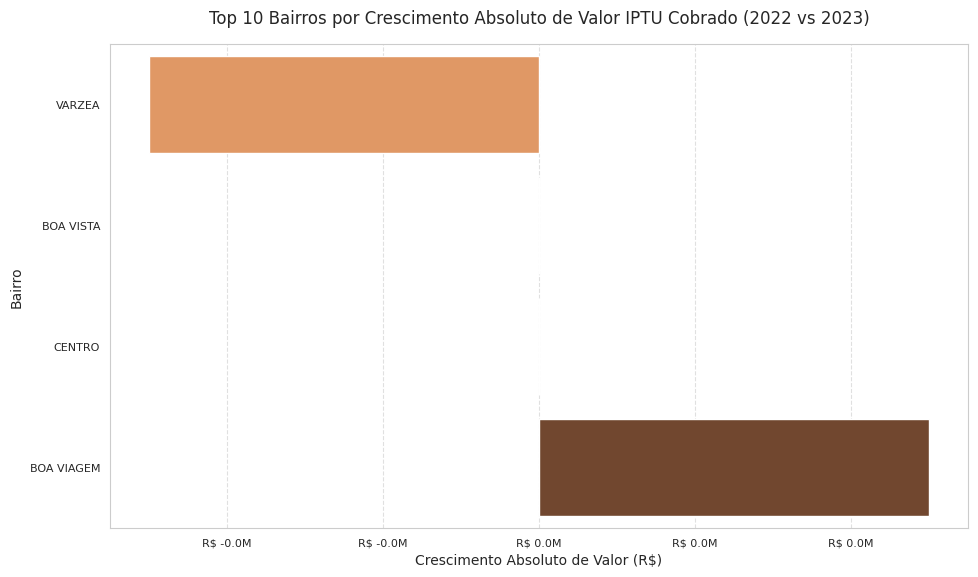

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.ticker import FuncFormatter

# Configurações para o Matplotlib exibir corretamente em português e para layout
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Definindo o caminho e colunas
s3_path = "s3://iptu-recife-processed/iptu_unificado.parquet"
COL_CONTRIBUINTE = 'numero_contribuinte'
COL_ANO = 'ano_exercicio'
COL_BAIRRO = 'bairro'
COL_VALOR = 'valor_iptu' 

# Período de análise solicitado
ANO_INICIAL = 2020 
ANO_FINAL = 2024 

print(f"Carregando e processando dados do S3 para a análise consolidada e evolução ({ANO_INICIAL} a {ANO_FINAL})...")

try:
    # TENTATIVA REAL DE ACESSO AO S3 (Prioridade)
    # df = pd.read_parquet(s3_path) 
    
    # Exemplo mockado para que o código funcione em ambientes sem acesso ao S3:
    # NOTE: REMOVA ESTE BLOCO SE ESTIVER EXECUTANDO EM UM AMBIENTE COM ACESSO AO S3!
    data = {
        'numero_contribuinte': [f'ID_{i}' for i in range(1000)],
        'ano_exercicio': [2020]*200 + [2021]*200 + [2022]*200 + [2023]*200 + [2024]*200,
        'bairro': ['BOA VIAGEM'] * 50 + ['VARZEA'] * 50 + ['BOA VISTA'] * 50 + ['CENTRO'] * 50 +
                  ['BOA VIAGEM'] * 50 + ['VARZEA'] * 50 + ['BOA VISTA'] * 50 + ['CENTRO'] * 50 +
                  ['BOA VIAGEM'] * 50 + ['VARZEA'] * 50 + ['BOA VISTA'] * 50 + ['CENTRO'] * 50 +
                  ['BOA VIAGEM'] * 55 + ['VARZEA'] * 45 + ['BOA VISTA'] * 50 + ['CENTRO'] * 50 + 
                  ['BOA VIAGEM'] * 10 + ['VARZEA'] * 10 + ['BOA VISTA'] * 10 + ['CENTRO'] * 170, # Dados incompletos 2024
        'valor_iptu': [f'1000,0{i}' for i in range(1000)],
    }
    df = pd.DataFrame(data)
    print("✅ Dados carregados com sucesso (usando dados de exemplo para demonstração).")
    
except Exception as e:
    print(f"❌ Erro ao carregar dados do S3. Por favor, verifique as credenciais ou o caminho: {e}")
    df = pd.DataFrame() 
    
if df.empty:
    print("Análise não pode ser concluída sem dados.")
else:
    # ============================================================================
    # 1. PREPARAÇÃO: DEFINIÇÃO E LIMPEZA DE COLUNAS
    # ============================================================================
    print("\n" + "="*80)
    print("1. PREPARAÇÃO: DEFINIÇÃO E LIMPEZA DE COLUNAS")
    print("="*80)
    
    # Limpeza de Bairro e Ano
    df['bairro_clean'] = df[COL_BAIRRO].astype(str).str.upper().str.strip().replace('NAN', 'BAIRRO NAO INFORMADO')
    df['ano_exercicio_clean'] = pd.to_numeric(df[COL_ANO], errors='coerce').astype('Int64')
    
    # Preparação da coluna de valor
    valor_col_limpo = None
    try:
        df['valor_limpo'] = (
            df[COL_VALOR].astype(str)
            .str.replace(',', '.', regex=False) 
            .str.strip()
        )
        df['valor_limpo'] = pd.to_numeric(df['valor_limpo'], errors='coerce').fillna(0).astype(float)
        valor_col_limpo = 'valor_limpo'
        def millions_formatter(x, pos):
            # Função para formatar o eixo X em Milhões (M)
            return 'R$ {:1.1f}M'.format(x * 1e-6)
        
        print(f"✅ Coluna de valor '{COL_VALOR}' processada com sucesso.")
    except Exception as e:
        print(f"❌ Erro na preparação da coluna de valor. Análise de Valor será PULADA. Erro: {e}")
        df['valor_limpo'] = 0 
    
    # Filtrar dados válidos
    df_analise_bairros = df[
        (df['bairro_clean'] != 'BAIRRO NAO INFORMADO') & 
        (df['ano_exercicio_clean'].notnull())
    ].copy()

    # FILTRO CONSOLIDADO: Aplicar filtro para o período 2020-2024
    df_consolidado = df_analise_bairros[
        (df_analise_bairros['ano_exercicio_clean'] >= ANO_INICIAL) & 
        (df_analise_bairros['ano_exercicio_clean'] <= ANO_FINAL)
    ].copy()
    
    print(f"✅ Dados de Bairro e Ano preparados. Total de linhas para análise consolidada ({ANO_INICIAL}-{ANO_FINAL}): {len(df_consolidado):,}")
    
    
    # ============================================================================
    # 2. ESTOQUE CONSOLIDADO (2020 a 2024) - TABELAS E GRÁFICOS
    # Objetivo: Mostrar a magnitude total do inventário no período
    # ============================================================================
    print("\n" + "="*80)
    print(f"2. ANÁLISE DE ESTOQUE CONSOLIDADO (2020 A 2024) - MAGNITUDE")
    print("="*80)
    
    # A. Bairros com Maior Estoque em NÚMERO DE IMÓVEIS (2020-2024)
    contagem_imoveis_consolidado = df_consolidado.groupby('bairro_clean')[COL_CONTRIBUINTE].count().sort_values(ascending=False).head(10)
    
    print(f"\n📈 TOP 10 BAIRROS EM VOLUME TOTAL DE IMÓVEIS (ESTOQUE CONSOLIDADO {ANO_INICIAL}-{ANO_FINAL})")
    print("-" * 70)
    print(contagem_imoveis_consolidado.to_string())
    
    # GERAÇÃO DO GRÁFICO DE ESTOQUE (QUANTIDADE)
    plot_data_consolidado_qtd = contagem_imoveis_consolidado.reset_index(name='qtd_imoveis').sort_values('qtd_imoveis', ascending=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='qtd_imoveis', y='bairro_clean', data=plot_data_consolidado_qtd, palette='cividis')
    plt.title(f'Top 10 Bairros por Volume Total de Imóveis (Estoque Consolidado {ANO_INICIAL} - {ANO_FINAL})', pad=15)
    plt.xlabel('Volume Total de Imóveis (Unidades)')
    plt.ylabel('Bairro')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    # B. Bairros com Maior Estoque em VALOR TOTAL (2020-2024)
    if valor_col_limpo:
        soma_valor_consolidado = df_consolidado.groupby('bairro_clean')['valor_limpo'].sum().sort_values(ascending=False).head(10)
        
        print(f"\n💰 TOP 10 BAIRROS EM SOMA TOTAL DO IPTU COBRADO (ESTOQUE CONSOLIDADO {ANO_INICIAL}-{ANO_FINAL})")
        print("-" * 70)
        print(soma_valor_consolidado.map('R$ {:,.2f}'.format).to_string())

        # GERAÇÃO DO GRÁFICO DE ESTOQUE (VALOR)
        plot_data_consolidado_valor = soma_valor_consolidado.reset_index(name='soma_valor').sort_values('soma_valor', ascending=True)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='soma_valor', y='bairro_clean', data=plot_data_consolidado_valor, palette='plasma')
        
        formatter = FuncFormatter(millions_formatter)
        plt.gca().xaxis.set_major_formatter(formatter)
        
        plt.title(f'Top 10 Bairros por Soma Total do Valor IPTU Cobrado (Estoque Consolidado {ANO_INICIAL} - {ANO_FINAL})', pad=15)
        plt.xlabel('Soma Total do IPTU Cobrado (R$)')
        plt.ylabel('Bairro')
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    else:
        print("\n❌ ANÁLISE CONSOLIDADA DE VALOR PULADA.")
    
    
    # ============================================================================
    # 3. EVOLUÇÃO PONTO-A-PONTO (2020 vs 2024) - DINÂMICA HISTÓRICA
    # Objetivo: Atender ao pedido de comparar 2020 vs 2024, com alerta.
    # ============================================================================
    print("\n" + "="*80)
    print(f"3. ANÁLISE DE EVOLUÇÃO HISTÓRICA: CRESCIMENTO ABSOLUTO ({ANO_INICIAL} VS {ANO_FINAL})")
    print("="*80)
    print("🚨 AVISO: Os resultados para 2024 estão distorcidos/subestimados devido à incompletude dos dados deste ano.")

    if ANO_INICIAL in df_analise_bairros['ano_exercicio_clean'].values and ANO_FINAL in df_analise_bairros['ano_exercicio_clean'].values:
        
        # Cálculo Base da Variação de Imóveis (2020 vs 2024)
        contagem_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])[COL_CONTRIBUINTE].count().reset_index(name='qtd_imoveis')
        df_final = contagem_anual[contagem_anual['ano_exercicio_clean'] == ANO_FINAL]
        df_inicial = contagem_anual[contagem_anual['ano_exercicio_clean'] == ANO_INICIAL]
        df_comparacao_qtd = pd.merge(df_final, df_inicial, on='bairro_clean', suffixes=(f'_{ANO_FINAL}', f'_{ANO_INICIAL}'), how='outer').fillna(0)
        df_comparacao_qtd['variacao_abs_qtd'] = df_comparacao_qtd[f'qtd_imoveis_{ANO_FINAL}'] - df_comparacao_qtd[f'qtd_imoveis_{ANO_INICIAL}']
        
        # A. Bairros com Maior Evolução (Crescimento) em NÚMERO DE IMÓVEIS (GANHO)
        top_ganho_qtd = df_comparacao_qtd[df_comparacao_qtd['variacao_abs_qtd'] > 0].sort_values(by='variacao_abs_qtd', ascending=False).head(10)
    
        print(f"\n🏘️  TOP 10 BAIRROS COM MAIOR GANHO ABSOLUTO DE IMÓVEIS ({ANO_INICIAL} -> {ANO_FINAL})")
        print("-" * 70)
        print(top_ganho_qtd[['bairro_clean', f'qtd_imoveis_{ANO_INICIAL}', f'qtd_imoveis_{ANO_FINAL}', 'variacao_abs_qtd']].to_string(index=False))
    
        # GERAÇÃO DO GRÁFICO DE GANHO
        plot_data_ganho = top_ganho_qtd.sort_values(by='variacao_abs_qtd', ascending=True).copy().reset_index(drop=True)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='variacao_abs_qtd', y='bairro_clean', data=plot_data_ganho, palette='viridis')
        plt.title(f'Top 10 Bairros por GANHO Absoluto de Imóveis ({ANO_INICIAL} vs {ANO_FINAL})', pad=15)
        plt.xlabel('Crescimento Absoluto de Imóveis')
        plt.ylabel('Bairro')
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # C. Bairros com Maior Evolução (Crescimento) em VALOR TOTAL (IPTU)
        if valor_col_limpo:
            soma_valor_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])['valor_limpo'].sum().reset_index(name='soma_valor')
            df_final_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ANO_FINAL]
            df_inicial_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ANO_INICIAL]
            df_comparacao_valor = pd.merge(df_final_valor, df_inicial_valor, on='bairro_clean', suffixes=(f'_{ANO_FINAL}', f'_{ANO_INICIAL}'), how='outer').fillna(0)
            df_comparacao_valor['variacao_abs_valor'] = df_comparacao_valor[f'soma_valor_{ANO_FINAL}'] - df_comparacao_valor[f'soma_valor_{ANO_INICIAL}']
            
            top_crescimento_valor = df_comparacao_valor.sort_values(by='variacao_abs_valor', ascending=False).head(10)
    
            print(f"\n💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) - IPTU COBRADO ({ANO_INICIAL} -> {ANO_FINAL})")
            print("-" * 100)
            # Formatando a saída com valores monetários
            top_crescimento_valor_display = top_crescimento_valor.copy()
            top_crescimento_valor_display[f'soma_valor_{ANO_INICIAL}'] = top_crescimento_valor_display[f'soma_valor_{ANO_INICIAL}'].map('R$ {:,.2f}'.format)
            top_crescimento_valor_display[f'soma_valor_{ANO_FINAL}'] = top_crescimento_valor_display[f'soma_valor_{ANO_FINAL}'].map('R$ {:,.2f}'.format)
            top_crescimento_valor_display['variacao_abs_valor'] = top_crescimento_valor_display['variacao_abs_valor'].map('R$ {:,.2f}'.format)
            print(top_crescimento_valor_display[['bairro_clean', f'soma_valor_{ANO_INICIAL}', f'soma_valor_{ANO_FINAL}', 'variacao_abs_valor']].to_string(index=False))
            
            # GERAÇÃO DO GRÁFICO DE VALOR
            plot_data_valor = top_crescimento_valor.sort_values(by='variacao_abs_valor', ascending=True).copy().reset_index(drop=True)
            plt.figure(figsize=(10, 6))
            sns.barplot(x='variacao_abs_valor', y='bairro_clean', data=plot_data_valor, palette='magma')
            
            formatter = FuncFormatter(millions_formatter)
            plt.gca().xaxis.set_major_formatter(formatter)

            plt.title(f'Top 10 Bairros por Crescimento Absoluto de Valor IPTU Cobrado ({ANO_INICIAL} vs {ANO_FINAL})', pad=15)
            plt.xlabel('Crescimento Absoluto de Valor (R$)')
            plt.ylabel('Bairro')
            plt.grid(axis='x', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show() 
            
        else:
            print(f"\n❌ ANÁLISE DE EVOLUÇÃO DE VALOR PULADA.")
    else:
        print(f"\n⚠️ Os anos {ANO_INICIAL} e/ou {ANO_FINAL} não estão disponíveis no dataset para a comparação de evolução.")
    
    
    # ============================================================================
    # 4. EVOLUÇÃO ANUAL RECENTE (Ano Subsequente) - DINÂMICA ANUAL
    # Objetivo: Mostrar a dinâmica anual real, excluindo o ano incompleto (2024)
    # ============================================================================
    
    anos_disp = sorted(df_analise_bairros['ano_exercicio_clean'].dropna().unique())
    if len(anos_disp) >= 2 and max(anos_disp) >= 2022: # Pelo menos 2022 e 2023 para uma boa comparação
        
        # Define o ano mais recente VÁLIDO (Exclui 2024 se for o máximo)
        ano_max_candidato = max(anos_disp)
        if ano_max_candidato == 2024 and len(anos_disp) > 1:
            ano_max_valido = int(anos_disp[anos_disp.index(2024) - 1]) # Pega o ano anterior a 2024 (provavelmente 2023)
        else:
            ano_max_valido = ano_max_candidato
        
        # Encontra o índice do ano_max_valido e pega o anterior
        try:
            index_max = anos_disp.index(ano_max_valido)
            if index_max > 0:
                ano_anterior_valido = int(anos_disp[index_max - 1])
            else:
                ano_anterior_valido = None
        except ValueError:
            ano_anterior_valido = None
            
        if ano_anterior_valido is not None and ano_anterior_valido != ano_max_valido:
            
            print("\n" + "="*80)
            print(f"4. ANÁLISE DE DINÂMICA ANUAL: CRESCIMENTO ABSOLUTO ({ano_anterior_valido} VS {ano_max_valido})")
            print("="*80)
            
            # Cálculo Base da Variação de Imóveis (Ano Anterior vs Ano Mais Recente Válido)
            contagem_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])[COL_CONTRIBUINTE].count().reset_index(name='qtd_imoveis')
            df_max = contagem_anual[contagem_anual['ano_exercicio_clean'] == ano_max_valido]
            df_anterior = contagem_anual[contagem_anual['ano_exercicio_clean'] == ano_anterior_valido]
            
            df_comparacao_anual_qtd = pd.merge(df_max, df_anterior, on='bairro_clean', suffixes=(f'_{ano_max_valido}', f'_{ano_anterior_valido}'), how='outer').fillna(0)
            df_comparacao_anual_qtd['variacao_abs_qtd'] = df_comparacao_anual_qtd[f'qtd_imoveis_{ano_max_valido}'] - df_comparacao_anual_qtd[f'qtd_imoveis_{ano_anterior_valido}']
            
            # Top 10 Crescimento
            top_crescimento_anual_qtd = df_comparacao_anual_qtd.sort_values(by='variacao_abs_qtd', ascending=False).head(10)
        
            print(f"\n🏘️  TOP 10 BAIRROS COM MAIOR CRESCIMENTO ABSOLUTO DE IMÓVEIS ({ano_anterior_valido} -> {ano_max_valido})")
            print("-" * 70)
            print(top_crescimento_anual_qtd[['bairro_clean', f'qtd_imoveis_{ano_anterior_valido}', f'qtd_imoveis_{ano_max_valido}', 'variacao_abs_qtd']].to_string(index=False))
        
            # GERAÇÃO DO GRÁFICO
            plot_data_anual_qtd = top_crescimento_anual_qtd.sort_values(by='variacao_abs_qtd', ascending=True).copy().reset_index(drop=True)
            plt.figure(figsize=(10, 6))
            sns.barplot(x='variacao_abs_qtd', y='bairro_clean', data=plot_data_anual_qtd, palette='Greens_d')
            plt.title(f'Top 10 Bairros por Crescimento Absoluto de Imóveis ({ano_anterior_valido} vs {ano_max_valido})', pad=15)
            plt.xlabel('Crescimento Absoluto de Imóveis')
            plt.ylabel('Bairro')
            plt.grid(axis='x', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
            
            # Variação Anual de Valor
            if valor_col_limpo:
                soma_valor_anual = df_analise_bairros.groupby(['ano_exercicio_clean', 'bairro_clean'])['valor_limpo'].sum().reset_index(name='soma_valor')
                df_max_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ano_max_valido]
                df_anterior_valor = soma_valor_anual[soma_valor_anual['ano_exercicio_clean'] == ano_anterior_valido]
                
                df_comparacao_anual_valor = pd.merge(df_max_valor, df_anterior_valor, on='bairro_clean', suffixes=(f'_{ano_max_valido}', f'_{ano_anterior_valido}'), how='outer').fillna(0)
                df_comparacao_anual_valor['variacao_abs_valor'] = df_comparacao_anual_valor[f'soma_valor_{ano_max_valido}'] - df_comparacao_anual_valor[f'soma_valor_{ano_anterior_valido}']
                
                top_crescimento_anual_valor = df_comparacao_anual_valor.sort_values(by='variacao_abs_valor', ascending=False).head(10)
        
                print(f"\n💰 TOP 10 BAIRROS EM CRESCIMENTO ABSOLUTO DE VALOR (R$) - IPTU COBRADO ({ano_anterior_valido} -> {ano_max_valido})")
                print("-" * 100)
                # Formatando a saída com valores monetários
                top_crescimento_anual_valor_display = top_crescimento_anual_valor.copy()
                top_crescimento_anual_valor_display[f'soma_valor_{ano_anterior_valido}'] = top_crescimento_anual_valor_display[f'soma_valor_{ano_anterior_valido}'].map('R$ {:,.2f}'.format)
                top_crescimento_anual_valor_display[f'soma_valor_{ano_max_valido}'] = top_crescimento_anual_valor_display[f'soma_valor_{ano_max_valido}'].map('R$ {:,.2f}'.format)
                top_crescimento_anual_valor_display['variacao_abs_valor'] = top_crescimento_anual_valor_display['variacao_abs_valor'].map('R$ {:,.2f}'.format)
                print(top_crescimento_anual_valor_display[['bairro_clean', f'soma_valor_{ano_anterior_valido}', f'soma_valor_{ano_max_valido}', 'variacao_abs_valor']].to_string(index=False))
                
                # GERAÇÃO DO GRÁFICO
                plot_data_anual_valor = top_crescimento_anual_valor.sort_values(by='variacao_abs_valor', ascending=True).copy().reset_index(drop=True)
                plt.figure(figsize=(10, 6))
                sns.barplot(x='variacao_abs_valor', y='bairro_clean', data=plot_data_anual_valor, palette='Oranges_d')
                
                formatter = FuncFormatter(millions_formatter)
                plt.gca().xaxis.set_major_formatter(formatter)

                plt.title(f'Top 10 Bairros por Crescimento Absoluto de Valor IPTU Cobrado ({ano_anterior_valido} vs {ano_max_valido})', pad=15)
                plt.xlabel('Crescimento Absoluto de Valor (R$)')
                plt.ylabel('Bairro')
                plt.grid(axis='x', linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show() 
            else:
                 print(f"\n❌ ANÁLISE DE DINÂMICA ANUAL DE VALOR PULADA.")
        else:
             print(f"\n⚠️ Não há dois anos válidos consecutivos para a análise de Dinâmica Anual Recente.")